# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-15 04:03:35,461 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_simulated_weekly.csv"
)

dt_prophet_holidays = pd.read_csv(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/tutorials/resources/dt_prophet_holidays.csv"
)

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00


,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-15 04:03:37,749 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-15 04:03:37,751 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-15 04:03:37,751 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-15 04:03:38,365 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpf_gggk9h/w_ps12tx.json
2024-11-15 04:03:38,374 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

All ind vars ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']


2024-11-15 04:03:38,593 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-15 04:03:38,594 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-15 04:03:38,757 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


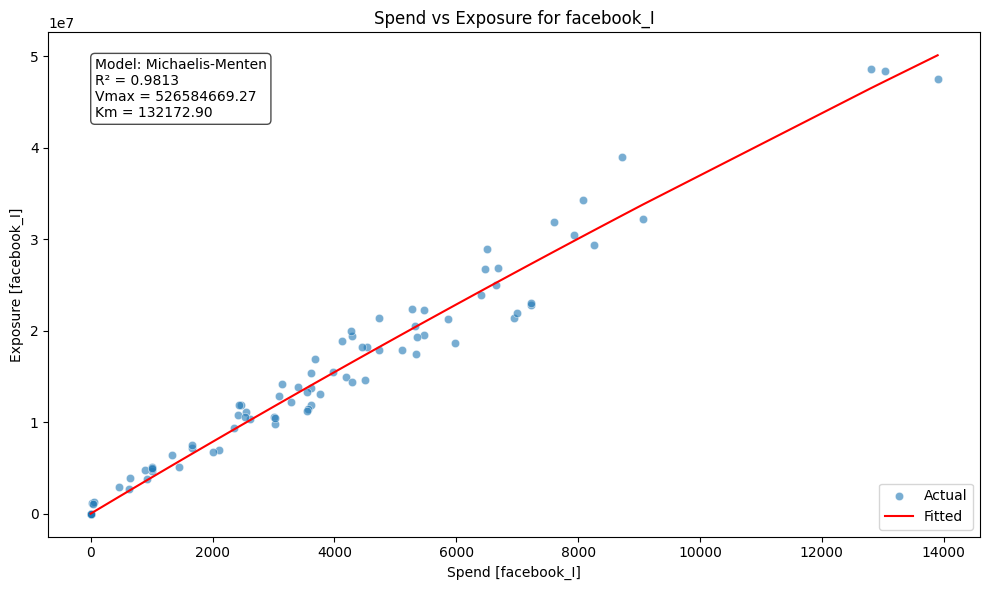

2024-11-15 04:03:38,850 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-15 04:03:39,002 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


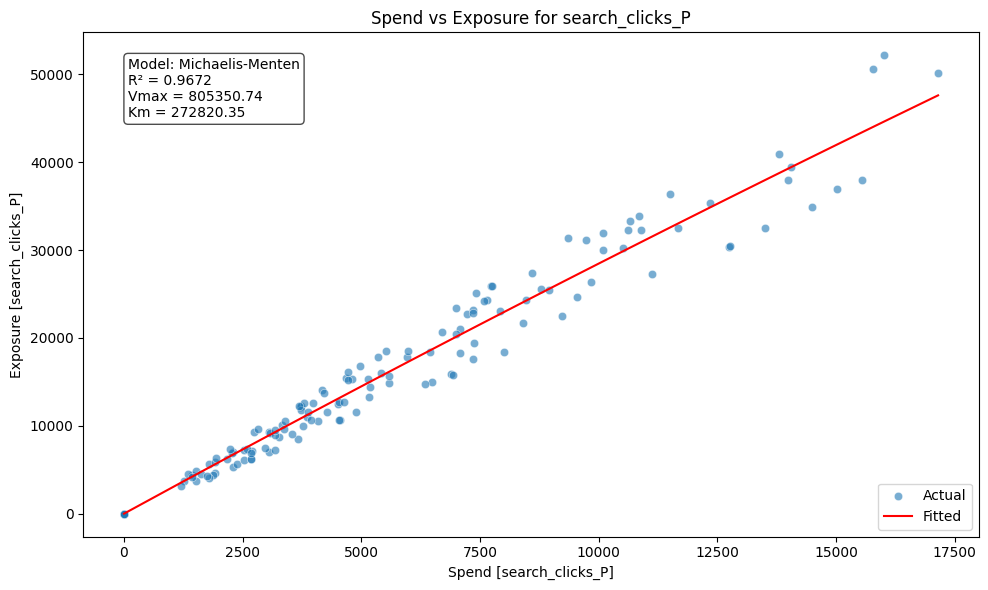

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-15 04:03:39,094 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-15 04:03:39,095 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-15 04:03:39,095 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-15 04:03:39,096 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-15 04:03:39,096 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-15 04:03:39,096 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-15 04:03:39,097 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-15 04:03:39,097 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 54 iterations each using TwoPointsDE nevergrad algorithm on x cores...


Running trial 1 of total 5 trials:   4%|█▎                                 


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 1.080875e-01
  Coef (unscaled): 1.709263e+06
  Effect: 6.015471e+07
  Spend: 3.519336e+01
Column ooh_S:
  Coef (raw): 2.659429e-02
  Coef (unscaled): 4.625314e+05
  Effect: 9.467098e+06
  Spend: 2.046801e+01
Column print_S:
  Coef (raw): 3.767594e-02
  Coef (unscaled): 5.169565e+05
  Effect: 1.102591e+07
  Spend: 2.132852e+01
Column facebook_S:
  Coef (raw): 6.428477e-02
  Coef (unscaled): 8.825752e+05
  Effect: 2.044925e+07
  Spend: 2.316998e+01
Column search_S:
  Coef (raw): 5.813657e-02
  Coef (unscaled): 6.196740e+05
  Effect: 2.130553e+07
  Spend: 3.438184e+01

RSSD summary:
Total effect: 1.22e+08
Total spend: 1.35e+02
Number of zeros: 0
Base RSSD: 0.118140
Scaled RSSD: 118.139956
Final RSSD: 118.139956

RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.222638e-02
  Coef (unscaled): 1.756203e+06
  Effect: 4.139508e+07
  Spend: 2.357078e+01
Column ooh

Running trial 1 of total 5 trials:   7%|██▌                                


RSSD calculation debug:
Y scale - mean: 7.57e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.440255e-01
  Coef (unscaled): 1.702429e+06
  Effect: 3.878867e+07
  Spend: 2.278431e+01
Column ooh_S:
  Coef (raw): 3.220963e-02
  Coef (unscaled): 5.344981e+05
  Effect: 7.747829e+06
  Spend: 1.449552e+01
Column print_S:
  Coef (raw): 5.884711e-02
  Coef (unscaled): 5.765710e+05
  Effect: 1.247427e+07
  Spend: 2.163526e+01
Column facebook_S:
  Coef (raw): 9.800655e-02
  Coef (unscaled): 1.105417e+06
  Effect: 2.641182e+07
  Spend: 2.389309e+01
Column search_S:
  Coef (raw): 8.643029e-02
  Coef (unscaled): 2.501869e+06
  Effect: 2.095178e+07
  Spend: 8.374454e+00

RSSD summary:
Total effect: 1.06e+08
Total spend: 9.12e+01
Number of zeros: 0
Base RSSD: 0.096158
Scaled RSSD: 96.157993
Final RSSD: 96.157993


Running trial 1 of total 5 trials:  11%|███▉                               


RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.148816e-02
  Coef (unscaled): 8.094538e+05
  Effect: 2.189853e+07
  Spend: 2.705347e+01
Column ooh_S:
  Coef (raw): 2.491163e-02
  Coef (unscaled): 2.561509e+05
  Effect: 6.975149e+06
  Spend: 2.723062e+01
Column print_S:
  Coef (raw): 3.326547e-02
  Coef (unscaled): 7.140539e+05
  Effect: 6.537453e+06
  Spend: 9.155405e+00
Column facebook_S:
  Coef (raw): 4.301174e-02
  Coef (unscaled): 7.378906e+05
  Effect: 9.460395e+06
  Spend: 1.282086e+01
Column search_S:
  Coef (raw): 5.860138e-02
  Coef (unscaled): 1.235102e+06
  Effect: 1.806758e+07
  Spend: 1.462842e+01

RSSD summary:
Total effect: 6.29e+07
Total spend: 9.09e+01
Number of zeros: 0
Base RSSD: 0.104083
Scaled RSSD: 104.082975
Final RSSD: 104.082975

RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.323201e-01
  Coef (unscaled): 2.461424e+06
  Effect: 1.143007e+08
  Spend: 4.643681e+01
Column ooh

Running trial 1 of total 5 trials:  15%|█████▏                             


RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 6.345429e-02
  Coef (unscaled): 1.544599e+06
  Effect: 1.406375e+07
  Spend: 9.105114e+00
Column ooh_S:
  Coef (raw): 1.878933e-02
  Coef (unscaled): 3.963317e+05
  Effect: 5.637354e+06
  Spend: 1.422383e+01
Column print_S:
  Coef (raw): 3.606306e-02
  Coef (unscaled): 4.500644e+05
  Effect: 1.308159e+07
  Spend: 2.906604e+01
Column facebook_S:
  Coef (raw): 1.049997e-02
  Coef (unscaled): 4.006141e+05
  Effect: 1.495666e+06
  Spend: 3.733433e+00
Column search_S:
  Coef (raw): 4.510975e-02
  Coef (unscaled): 1.003318e+06
  Effect: 2.502591e+07
  Spend: 2.494315e+01

RSSD summary:
Total effect: 5.93e+07
Total spend: 8.11e+01
Number of zeros: 0
Base RSSD: 0.104477
Scaled RSSD: 104.477223
Final RSSD: 104.477223


Running trial 1 of total 5 trials:  19%|██████▍                            


RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 9.033889e-02
  Coef (unscaled): 1.238988e+06
  Effect: 6.647348e+07
  Spend: 5.365141e+01
Column ooh_S:
  Coef (raw): 2.043322e-02
  Coef (unscaled): 4.800046e+05
  Effect: 9.434438e+06
  Spend: 1.965489e+01
Column print_S:
  Coef (raw): 2.739720e-02
  Coef (unscaled): 2.762947e+05
  Effect: 1.117363e+07
  Spend: 4.044097e+01
Column facebook_S:
  Coef (raw): 4.522878e-02
  Coef (unscaled): 9.644278e+05
  Effect: 1.472872e+07
  Spend: 1.527198e+01
Column search_S:
  Coef (raw): 4.959744e-02
  Coef (unscaled): 1.079688e+06
  Effect: 2.582147e+07
  Spend: 2.391567e+01

RSSD summary:
Total effect: 1.28e+08
Total spend: 1.53e+02
Number of zeros: 0
Base RSSD: 0.114477
Scaled RSSD: 114.477032
Final RSSD: 114.477032

RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 7.714217e-02
  Coef (unscaled): 1.618316e+06
  Effect: 2.058261e+07
  Spend: 1.271853e+01
Column ooh

Running trial 1 of total 5 trials:  22%|███████▊                           


RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.322674e-02
  Coef (unscaled): 1.302246e+06
  Effect: 2.986346e+07
  Spend: 2.293227e+01
Column ooh_S:
  Coef (raw): 1.771479e-02
  Coef (unscaled): 3.141532e+05
  Effect: 6.138869e+06
  Spend: 1.954101e+01
Column print_S:
  Coef (raw): 2.912329e-02
  Coef (unscaled): 6.131988e+05
  Effect: 7.672504e+06
  Spend: 1.251226e+01
Column facebook_S:
  Coef (raw): 5.962838e-02
  Coef (unscaled): 1.035835e+06
  Effect: 3.634996e+07
  Spend: 3.509241e+01
Column search_S:
  Coef (raw): 3.859479e-02
  Coef (unscaled): 7.849747e+05
  Effect: 2.983547e+07
  Spend: 3.800819e+01

RSSD summary:
Total effect: 1.10e+08
Total spend: 1.28e+02
Number of zeros: 0
Base RSSD: 0.067237
Scaled RSSD: 67.237390
Final RSSD: 67.237390

RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 8.603841e-02
  Coef (unscaled): 9.848473e+05
  Effect: 2.804095e+07
  Spend: 2.847238e+01
Column ooh_S

Running trial 1 of total 5 trials:  30%|██████████▎                        


RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 6.216538e-02
  Coef (unscaled): 8.398577e+05
  Effect: 1.053389e+07
  Spend: 1.254247e+01
Column ooh_S:
  Coef (raw): 9.143964e-03
  Coef (unscaled): 2.420514e+05
  Effect: 1.258853e+06
  Spend: 5.200767e+00
Column print_S:
  Coef (raw): 2.701207e-02
  Coef (unscaled): 7.055658e+05
  Effect: 3.540211e+06
  Spend: 5.017548e+00
Column facebook_S:
  Coef (raw): 6.602088e-02
  Coef (unscaled): 1.767549e+06
  Effect: 1.809445e+07
  Spend: 1.023703e+01
Column search_S:
  Coef (raw): 5.902886e-02
  Coef (unscaled): 9.219533e+05
  Effect: 2.128995e+07
  Spend: 2.309222e+01

RSSD summary:
Total effect: 5.47e+07
Total spend: 5.61e+01
Number of zeros: 0
Base RSSD: 0.076037
Scaled RSSD: 76.037237
Final RSSD: 76.037237

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 6.389183e-02
  Coef (unscaled): 1.662719e+06
  Effect: 1.233244e+07
  Spend: 7.417033e+00
Column ooh_S

Running trial 1 of total 5 trials:  33%|███████████▋                       


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 6.557747e-02
  Coef (unscaled): 6.429244e+05
  Effect: 1.641517e+07
  Spend: 2.553204e+01
Column ooh_S:
  Coef (raw): 1.901418e-02
  Coef (unscaled): 3.854727e+05
  Effect: 6.378137e+06
  Spend: 1.654627e+01
Column print_S:
  Coef (raw): 2.930312e-02
  Coef (unscaled): 5.128307e+05
  Effect: 9.360133e+06
  Spend: 1.825190e+01
Column facebook_S:
  Coef (raw): 5.139102e-02
  Coef (unscaled): 7.953416e+05
  Effect: 2.082003e+07
  Spend: 2.617746e+01
Column search_S:
  Coef (raw): 4.707259e-02
  Coef (unscaled): 9.902598e+05
  Effect: 1.686752e+07
  Spend: 1.703343e+01

RSSD summary:
Total effect: 6.98e+07
Total spend: 1.04e+02
Number of zeros: 0
Base RSSD: 0.054016
Scaled RSSD: 54.016478
Final RSSD: 54.016478


Running trial 1 of total 5 trials:  37%|████████████▉                      


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.260699e-01
  Coef (unscaled): 2.216773e+06
  Effect: 7.264357e+07
  Spend: 3.276996e+01
Column ooh_S:
  Coef (raw): 2.806329e-02
  Coef (unscaled): 3.147825e+05
  Effect: 6.836867e+06
  Spend: 2.171934e+01
Column print_S:
  Coef (raw): 4.645776e-02
  Coef (unscaled): 9.070546e+05
  Effect: 1.123055e+07
  Spend: 1.238134e+01
Column facebook_S:
  Coef (raw): 8.909376e-02
  Coef (unscaled): 2.251378e+06
  Effect: 2.378609e+07
  Spend: 1.056512e+01
Column search_S:
  Coef (raw): 7.442309e-02
  Coef (unscaled): 1.856461e+06
  Effect: 1.619974e+07
  Spend: 8.726139e+00

RSSD summary:
Total effect: 1.31e+08
Total spend: 8.62e+01
Number of zeros: 0
Base RSSD: 0.124963
Scaled RSSD: 124.962965
Final RSSD: 124.962965

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.347966e-02
  Coef (unscaled): 3.347966e+06
  Effect: 1.298296e+07
  Spend: 3.877866e+00
Column ooh

Running trial 1 of total 5 trials:  44%|███████████████▌                   


RSSD calculation debug:
Y scale - mean: 7.52e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 1.229974e-01
  Coef (unscaled): 2.259524e+06
  Effect: 3.763150e+07
  Spend: 1.665462e+01
Column ooh_S:
  Coef (raw): 2.308780e-02
  Coef (unscaled): 3.730674e+05
  Effect: 5.429795e+06
  Spend: 1.455446e+01
Column print_S:
  Coef (raw): 5.045719e-02
  Coef (unscaled): 8.029722e+05
  Effect: 3.000289e+07
  Spend: 3.736480e+01
Column facebook_S:
  Coef (raw): 5.361698e-02
  Coef (unscaled): 1.595862e+06
  Effect: 1.521657e+07
  Spend: 9.535014e+00
Column search_S:
  Coef (raw): 8.509314e-02
  Coef (unscaled): 1.561118e+06
  Effect: 3.860877e+07
  Spend: 2.473149e+01

RSSD summary:
Total effect: 1.27e+08
Total spend: 1.03e+02
Number of zeros: 0
Base RSSD: 0.098771
Scaled RSSD: 98.771024
Final RSSD: 98.771024

RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 8.665128e-02
  Coef (unscaled): 1.250282e+06
  Effect: 3.035787e+07
  Spend: 2.428082e+01
Column ooh_S

Running trial 1 of total 5 trials:  48%|████████████████▊                  


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 8.429065e-02
  Coef (unscaled): 1.839434e+06
  Effect: 2.855789e+07
  Spend: 1.552537e+01
Column ooh_S:
  Coef (raw): 1.860683e-02
  Coef (unscaled): 3.834629e+05
  Effect: 4.161152e+06
  Spend: 1.085151e+01
Column print_S:
  Coef (raw): 3.600079e-02
  Coef (unscaled): 5.101079e+05
  Effect: 8.837760e+06
  Spend: 1.732527e+01
Column facebook_S:
  Coef (raw): 5.278398e-02
  Coef (unscaled): 7.006057e+05
  Effect: 1.401118e+07
  Spend: 1.999867e+01
Column search_S:
  Coef (raw): 3.793918e-02
  Coef (unscaled): 5.290725e+05
  Effect: 2.907104e+07
  Spend: 5.494718e+01

RSSD summary:
Total effect: 8.46e+07
Total spend: 1.19e+02
Number of zeros: 0
Base RSSD: 0.110007
Scaled RSSD: 110.007314
Final RSSD: 110.007314


Running trial 1 of total 5 trials:  52%|██████████████████▏                


RSSD calculation debug:
Y scale - mean: 7.50e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 8.595399e-02
  Coef (unscaled): 1.413328e+06
  Effect: 2.752428e+07
  Spend: 1.947480e+01
Column ooh_S:
  Coef (raw): 1.168633e-02
  Coef (unscaled): 2.103362e+05
  Effect: 2.302735e+06
  Spend: 1.094788e+01
Column print_S:
  Coef (raw): 2.986981e-02
  Coef (unscaled): 3.269534e+05
  Effect: 9.345445e+06
  Spend: 2.858342e+01
Column facebook_S:
  Coef (raw): 2.023751e-02
  Coef (unscaled): 7.007855e+05
  Effect: 4.128886e+06
  Spend: 5.891797e+00
Column search_S:
  Coef (raw): 5.449424e-02
  Coef (unscaled): 8.595411e+05
  Effect: 2.726975e+07
  Spend: 3.172595e+01

RSSD summary:
Total effect: 7.06e+07
Total spend: 9.66e+01
Number of zeros: 0
Base RSSD: 0.120088
Scaled RSSD: 120.087768
Final RSSD: 120.087768

RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 7.016212e-02
  Coef (unscaled): 1.086372e+06
  Effect: 1.814591e+07
  Spend: 1.670322e+01
Column ooh

Running trial 1 of total 5 trials:  56%|███████████████████▍               


RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.465949e-01
  Coef (unscaled): 2.791444e+06
  Effect: 6.137649e+07
  Spend: 2.198736e+01
Column ooh_S:
  Coef (raw): 3.609684e-02
  Coef (unscaled): 4.623611e+05
  Effect: 1.579348e+07
  Spend: 3.415831e+01
Column print_S:
  Coef (raw): 4.039628e-02
  Coef (unscaled): 1.244734e+06
  Effect: 8.051088e+06
  Spend: 6.468122e+00
Column facebook_S:
  Coef (raw): 7.667219e-02
  Coef (unscaled): 8.261652e+05
  Effect: 2.745141e+07
  Spend: 3.322751e+01
Column search_S:
  Coef (raw): 6.550732e-02
  Coef (unscaled): 7.607895e+05
  Effect: 4.587966e+07
  Spend: 6.030533e+01

RSSD summary:
Total effect: 1.59e+08
Total spend: 1.56e+02
Number of zeros: 0
Base RSSD: 0.131069
Scaled RSSD: 131.069188
Final RSSD: 131.069188


Running trial 1 of total 5 trials:  59%|████████████████████▋              


RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 7.686242e-02
  Coef (unscaled): 1.220743e+06
  Effect: 1.820569e+07
  Spend: 1.491361e+01
Column ooh_S:
  Coef (raw): 2.291511e-02
  Coef (unscaled): 3.857529e+05
  Effect: 6.800749e+06
  Spend: 1.762981e+01
Column print_S:
  Coef (raw): 3.394507e-02
  Coef (unscaled): 4.644840e+05
  Effect: 7.305875e+06
  Spend: 1.572901e+01
Column facebook_S:
  Coef (raw): 7.286860e-02
  Coef (unscaled): 1.056639e+06
  Effect: 2.020686e+07
  Spend: 1.912371e+01
Column search_S:
  Coef (raw): 6.150743e-02
  Coef (unscaled): 1.279924e+06
  Effect: 1.472460e+07
  Spend: 1.150428e+01

RSSD summary:
Total effect: 6.72e+07
Total spend: 7.89e+01
Number of zeros: 0
Base RSSD: 0.087860
Scaled RSSD: 87.860122
Final RSSD: 87.860122

RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.194110e-01
  Coef (unscaled): 2.614126e+06
  Effect: 4.006439e+07
  Spend: 1.532611e+01
Column ooh_S

Running trial 1 of total 5 trials:  63%|██████████████████████             


RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.219442e-02
  Coef (unscaled): 8.164692e+05
  Effect: 2.208832e+07
  Spend: 2.705347e+01
Column ooh_S:
  Coef (raw): 1.685025e-02
  Coef (unscaled): 4.569141e+05
  Effect: 3.058402e+06
  Spend: 6.693603e+00
Column print_S:
  Coef (raw): 3.912064e-02
  Coef (unscaled): 5.521452e+05
  Effect: 1.485482e+07
  Spend: 2.690382e+01
Column facebook_S:
  Coef (raw): 4.240380e-02
  Coef (unscaled): 7.274609e+05
  Effect: 9.326677e+06
  Spend: 1.282086e+01
Column search_S:
  Coef (raw): 5.771006e-02
  Coef (unscaled): 8.828205e+05
  Effect: 2.052574e+07
  Spend: 2.325018e+01

RSSD summary:
Total effect: 6.99e+07
Total spend: 9.67e+01
Number of zeros: 0
Base RSSD: 0.042726
Scaled RSSD: 42.726250
Final RSSD: 42.726250


Running trial 1 of total 5 trials:  70%|████████████████████████▋          


RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.323551e-01
  Coef (unscaled): 2.462075e+06
  Effect: 1.143309e+08
  Spend: 4.643681e+01
Column ooh_S:
  Coef (raw): 2.981320e-02
  Coef (unscaled): 6.315987e+05
  Effect: 1.493130e+07
  Spend: 2.364048e+01
Column print_S:
  Coef (raw): 4.045454e-02
  Coef (unscaled): 8.396084e+05
  Effect: 1.991631e+07
  Spend: 2.372095e+01
Column facebook_S:
  Coef (raw): 7.258135e-02
  Coef (unscaled): 1.530983e+06
  Effect: 2.867343e+07
  Spend: 1.872877e+01
Column search_S:
  Coef (raw): 4.863615e-02
  Coef (unscaled): 7.965146e+05
  Effect: 3.513413e+07
  Spend: 4.410984e+01

RSSD summary:
Total effect: 2.13e+08
Total spend: 1.57e+02
Number of zeros: 0
Base RSSD: 0.127658
Scaled RSSD: 127.658398
Final RSSD: 127.658398

RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 9.213830e-02
  Coef (unscaled): 9.072904e+05
  Effect: 2.793991e+07
  Spend: 3.079490e+01
Column ooh

Running trial 1 of total 5 trials:  78%|███████████████████████████▏       


RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 1.086288e-01
  Coef (unscaled): 2.278855e+06
  Effect: 2.898369e+07
  Spend: 1.271853e+01
Column ooh_S:
  Coef (raw): 3.364686e-02
  Coef (unscaled): 6.736273e+05
  Effect: 1.364246e+07
  Spend: 2.025224e+01
Column print_S:
  Coef (raw): 4.294666e-02
  Coef (unscaled): 4.870859e+05
  Effect: 1.129919e+07
  Spend: 2.319753e+01
Column facebook_S:
  Coef (raw): 5.205672e-02
  Coef (unscaled): 7.144734e+05
  Effect: 1.333384e+07
  Spend: 1.866247e+01
Column search_S:
  Coef (raw): 6.700237e-02
  Coef (unscaled): 6.698045e+05
  Effect: 4.235020e+07
  Spend: 6.322771e+01

RSSD summary:
Total effect: 1.10e+08
Total spend: 1.38e+02
Number of zeros: 0
Base RSSD: 0.089118
Scaled RSSD: 89.117743
Final RSSD: 89.117743

RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 6.183941e-02
  Coef (unscaled): 1.018957e+06
  Effect: 1.311010e+07
  Spend: 1.286620e+01
Column ooh_S

Running trial 1 of total 5 trials:  85%|█████████████████████████████▊     


RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 6.232646e-02
  Coef (unscaled): 8.420339e+05
  Effect: 1.056119e+07
  Spend: 1.254247e+01
Column ooh_S:
  Coef (raw): 1.412531e-02
  Coef (unscaled): 3.527482e+05
  Effect: 2.562624e+06
  Spend: 7.264740e+00
Column print_S:
  Coef (raw): 2.658020e-02
  Coef (unscaled): 6.942850e+05
  Effect: 3.483608e+06
  Spend: 5.017548e+00
Column facebook_S:
  Coef (raw): 6.606543e-02
  Coef (unscaled): 1.768741e+06
  Effect: 1.810666e+07
  Spend: 1.023703e+01
Column search_S:
  Coef (raw): 5.895831e-02
  Coef (unscaled): 9.208513e+05
  Effect: 2.126450e+07
  Spend: 2.309222e+01

RSSD summary:
Total effect: 5.60e+07
Total spend: 5.82e+01
Number of zeros: 0
Base RSSD: 0.076944
Scaled RSSD: 76.944176
Final RSSD: 76.944176

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 6.415497e-02
  Coef (unscaled): 1.669567e+06
  Effect: 1.238323e+07
  Spend: 7.417033e+00
Column ooh_S

Running trial 1 of total 5 trials:  89%|███████████████████████████████    


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 6.559939e-02
  Coef (unscaled): 6.431394e+05
  Effect: 1.642066e+07
  Spend: 2.553204e+01
Column ooh_S:
  Coef (raw): 1.879503e-02
  Coef (unscaled): 3.810299e+05
  Effect: 6.304626e+06
  Spend: 1.654627e+01
Column print_S:
  Coef (raw): 2.798001e-02
  Coef (unscaled): 4.970866e+05
  Effect: 6.915028e+06
  Spend: 1.391111e+01
Column facebook_S:
  Coef (raw): 5.149827e-02
  Coef (unscaled): 7.970014e+05
  Effect: 2.086348e+07
  Spend: 2.617746e+01
Column search_S:
  Coef (raw): 4.709175e-02
  Coef (unscaled): 9.906628e+05
  Effect: 1.687438e+07
  Spend: 1.703343e+01

RSSD summary:
Total effect: 6.74e+07
Total spend: 9.92e+01
Number of zeros: 0
Base RSSD: 0.055238
Scaled RSSD: 55.238236
Final RSSD: 55.238236


Running trial 1 of total 5 trials:  93%|████████████████████████████████▍  


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 7.153105e-02
  Coef (unscaled): 7.895246e+05
  Effect: 1.753775e+07
  Spend: 2.221305e+01
Column ooh_S:
  Coef (raw): 9.956923e-03
  Coef (unscaled): 2.938978e+05
  Effect: 1.344531e+06
  Spend: 4.574827e+00
Column print_S:
  Coef (raw): 3.955267e-02
  Coef (unscaled): 7.140859e+05
  Effect: 2.464561e+07
  Spend: 3.451351e+01
Column facebook_S:
  Coef (raw): 4.201552e-02
  Coef (unscaled): 1.781778e+06
  Effect: 7.282997e+06
  Spend: 4.087487e+00
Column search_S:
  Coef (raw): 5.379290e-02
  Coef (unscaled): 1.018515e+06
  Effect: 1.142992e+07
  Spend: 1.122214e+01

RSSD summary:
Total effect: 6.22e+07
Total spend: 7.66e+01
Number of zeros: 0
Base RSSD: 0.044556
Scaled RSSD: 44.556304
Final RSSD: 44.556304

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.320183e-02
  Coef (unscaled): 3.338015e+06
  Effect: 1.294437e+07
  Spend: 3.877865e+00
Column ooh_S

Running trial 1 of total 5 trials:  96%|█████████████████████████████████▋ 


RSSD calculation debug:
Y scale - mean: 7.35e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.627104e-02
  Coef (unscaled): 1.309926e+06
  Effect: 1.146127e+07
  Spend: 8.749553e+00
Column ooh_S:
  Coef (raw): 2.354837e-02
  Coef (unscaled): 5.948622e+05
  Effect: 3.644665e+06
  Spend: 6.126907e+00
Column print_S:
  Coef (raw): 4.977914e-02
  Coef (unscaled): 1.261450e+06
  Effect: 8.767209e+06
  Spend: 6.950107e+00
Column facebook_S:
  Coef (raw): 6.530081e-02
  Coef (unscaled): 2.558470e+06
  Effect: 9.674466e+06
  Spend: 3.781347e+00
Column search_S:
  Coef (raw): 9.177456e-02
  Coef (unscaled): 1.748838e+06
  Effect: 2.208621e+07
  Spend: 1.262908e+01

RSSD summary:
Total effect: 5.56e+07
Total spend: 3.82e+01
Number of zeros: 0
Base RSSD: 0.063487
Scaled RSSD: 63.486725
Final RSSD: 63.486725

RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 7.731139e-02
  Coef (unscaled): 1.261289e+06
  Effect: 2.016677e+07
  Spend: 1.598902e+01
Column ooh_S

Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:03:42,427 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.06 mins



RSSD calculation debug:
Y scale - mean: 7.25e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.135165e-01
  Coef (unscaled): 2.259746e+06
  Effect: 2.054894e+07
  Spend: 9.093474e+00
Column ooh_S:
  Coef (raw): 2.406669e-02
  Coef (unscaled): 2.438370e+05
  Effect: 6.210314e+06
  Spend: 2.546912e+01
Column print_S:
  Coef (raw): 6.022521e-02
  Coef (unscaled): 7.514905e+05
  Effect: 1.517755e+07
  Spend: 2.019660e+01
Column facebook_S:
  Coef (raw): 1.846951e-02
  Coef (unscaled): 2.230954e+05
  Effect: 4.565829e+06
  Spend: 2.046581e+01
Column search_S:
  Coef (raw): 2.273429e-02
  Coef (unscaled): 2.331821e+05
  Effect: 9.084604e+06
  Spend: 3.895927e+01

RSSD summary:
Total effect: 5.56e+07
Total spend: 1.14e+02
Number of zeros: 0
Base RSSD: 0.171341
Scaled RSSD: 171.341189
Final RSSD: 171.341189


Running trial 2 of total 5 trials:   0%|                                   


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 9.108017e-02
  Coef (unscaled): 1.490262e+06
  Effect: 4.686879e+07
  Spend: 3.145005e+01
Column ooh_S:
  Coef (raw): 1.541467e-02
  Coef (unscaled): 2.801499e+05
  Effect: 2.948566e+06
  Spend: 1.052496e+01
Column print_S:
  Coef (raw): 3.331287e-02
  Coef (unscaled): 7.933858e+05
  Effect: 5.592261e+06
  Spend: 7.048603e+00
Column facebook_S:
  Coef (raw): 6.006900e-02
  Coef (unscaled): 1.864190e+06
  Effect: 1.296869e+07
  Spend: 6.956744e+00
Column search_S:
  Coef (raw): 5.874130e-02
  Coef (unscaled): 1.103894e+06
  Effect: 2.449955e+07
  Spend: 2.219375e+01

RSSD summary:
Total effect: 9.29e+07
Total spend: 7.82e+01
Number of zeros: 0
Base RSSD: 0.070600
Scaled RSSD: 70.600359
Final RSSD: 70.600359


Running trial 2 of total 5 trials:   4%|█▎                                 


RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.478998e-02
  Coef (unscaled): 1.314412e+06
  Effect: 5.601321e+07
  Spend: 4.261465e+01
Column ooh_S:
  Coef (raw): 2.242562e-02
  Coef (unscaled): 4.318330e+05
  Effect: 1.429610e+07
  Spend: 3.310562e+01
Column print_S:
  Coef (raw): 2.772333e-02
  Coef (unscaled): 4.907004e+05
  Effect: 5.141979e+06
  Spend: 1.047885e+01
Column facebook_S:
  Coef (raw): 5.430081e-02
  Coef (unscaled): 8.432543e+05
  Effect: 2.036353e+07
  Spend: 2.414874e+01
Column search_S:
  Coef (raw): 4.500832e-02
  Coef (unscaled): 5.220076e+05
  Effect: 2.334603e+07
  Spend: 4.472354e+01

RSSD summary:
Total effect: 1.19e+08
Total spend: 1.55e+02
Number of zeros: 0
Base RSSD: 0.106066
Scaled RSSD: 106.066168
Final RSSD: 106.066168

RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.180209e-01
  Coef (unscaled): 2.253016e+06
  Effect: 2.228012e+07
  Spend: 9.889021e+00
Column ooh

Running trial 2 of total 5 trials:   7%|██▌                                


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.142285e-01
  Coef (unscaled): 2.782508e+06
  Effect: 1.790531e+07
  Spend: 6.434951e+00
Column ooh_S:
  Coef (raw): 4.017150e-02
  Coef (unscaled): 4.742833e+05
  Effect: 1.295313e+07
  Spend: 2.731096e+01
Column print_S:
  Coef (raw): 5.762542e-02
  Coef (unscaled): 8.871858e+05
  Effect: 1.641008e+07
  Spend: 1.849678e+01
Column facebook_S:
  Coef (raw): 9.240313e-02
  Coef (unscaled): 1.653874e+06
  Effect: 2.521220e+07
  Spend: 1.524433e+01
Column search_S:
  Coef (raw): 1.026221e-01
  Coef (unscaled): 2.265768e+06
  Effect: 2.225150e+07
  Spend: 9.820734e+00

RSSD summary:
Total effect: 9.47e+07
Total spend: 7.73e+01
Number of zeros: 0
Base RSSD: 0.125559
Scaled RSSD: 125.559125
Final RSSD: 125.559125

RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 8.935324e-02
  Coef (unscaled): 2.084349e+06
  Effect: 1.389973e+07
  Spend: 6.668619e+00
Column ooh

Running trial 2 of total 5 trials:  11%|███▉                               


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.105505e-01
  Coef (unscaled): 1.945514e+06
  Effect: 2.347995e+07
  Spend: 1.206877e+01
Column ooh_S:
  Coef (raw): 3.090637e-02
  Coef (unscaled): 4.103357e+05
  Effect: 8.345510e+06
  Spend: 2.033825e+01
Column print_S:
  Coef (raw): 5.429944e-02
  Coef (unscaled): 6.907755e+05
  Effect: 2.380836e+07
  Spend: 3.446614e+01
Column facebook_S:
  Coef (raw): 7.924361e-02
  Coef (unscaled): 1.149231e+06
  Effect: 2.513622e+07
  Spend: 2.187221e+01
Column search_S:
  Coef (raw): 6.440319e-02
  Coef (unscaled): 1.056221e+06
  Effect: 3.568510e+07
  Spend: 3.378564e+01

RSSD summary:
Total effect: 1.16e+08
Total spend: 1.23e+02
Number of zeros: 0
Base RSSD: 0.074529
Scaled RSSD: 74.529339
Final RSSD: 74.529339

RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 1.478607e-01
  Coef (unscaled): 2.711900e+06
  Effect: 3.337289e+07
  Spend: 1.230609e+01
Column ooh_S

Running trial 2 of total 5 trials:  15%|█████▏                             


RSSD calculation debug:
Y scale - mean: 7.35e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 6.718569e-02
  Coef (unscaled): 1.013584e+06
  Effect: 1.340068e+07
  Spend: 1.322108e+01
Column ooh_S:
  Coef (raw): 1.451053e-02
  Coef (unscaled): 2.257269e+05
  Effect: 1.952232e+06
  Spend: 8.648645e+00
Column print_S:
  Coef (raw): 3.318448e-02
  Coef (unscaled): 4.960360e+05
  Effect: 7.145219e+06
  Spend: 1.440464e+01
Column facebook_S:
  Coef (raw): 5.294249e-02
  Coef (unscaled): 1.052845e+06
  Effect: 9.096528e+06
  Spend: 8.639946e+00
Column search_S:
  Coef (raw): 6.173768e-02
  Coef (unscaled): 1.434536e+06
  Effect: 1.487822e+07
  Spend: 1.037145e+01

RSSD summary:
Total effect: 4.65e+07
Total spend: 5.53e+01
Number of zeros: 0
Base RSSD: 0.095967
Scaled RSSD: 95.967218
Final RSSD: 95.967218

RSSD calculation debug:
Y scale - mean: 7.49e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 4.926706e-02
  Coef (unscaled): 1.205577e+06
  Effect: 7.310754e+06
  Spend: 6.064112e+00
Column ooh_S

Running trial 2 of total 5 trials:  19%|██████▍                            


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 5.306632e-02
  Coef (unscaled): 1.512246e+06
  Effect: 9.454406e+06
  Spend: 6.251895e+00
Column ooh_S:
  Coef (raw): 2.282365e-02
  Coef (unscaled): 4.345265e+05
  Effect: 8.145374e+06
  Spend: 1.874540e+01
Column print_S:
  Coef (raw): 2.853218e-02
  Coef (unscaled): 6.341127e+05
  Effect: 7.186208e+06
  Spend: 1.133270e+01
Column facebook_S:
  Coef (raw): 4.105645e-02
  Coef (unscaled): 5.359517e+05
  Effect: 9.989384e+06
  Spend: 1.863859e+01
Column search_S:
  Coef (raw): 4.855922e-02
  Coef (unscaled): 8.882682e+05
  Effect: 1.771774e+07
  Spend: 1.994639e+01

RSSD summary:
Total effect: 5.25e+07
Total spend: 7.49e+01
Number of zeros: 0
Base RSSD: 0.073601
Scaled RSSD: 73.600552
Final RSSD: 73.600552

RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.016278e-01
  Coef (unscaled): 1.052216e+06
  Effect: 2.621656e+07
  Spend: 2.491557e+01
Column ooh_S

Running trial 2 of total 5 trials:  22%|███████▊                           


RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 7.082324e-02
  Coef (unscaled): 1.259806e+06
  Effect: 3.353214e+07
  Spend: 2.661690e+01
Column ooh_S:
  Coef (raw): 2.296701e-02
  Coef (unscaled): 4.561445e+05
  Effect: 1.471422e+07
  Spend: 3.225780e+01
Column print_S:
  Coef (raw): 3.040638e-02
  Coef (unscaled): 3.682635e+05
  Effect: 1.182022e+07
  Spend: 3.209719e+01
Column facebook_S:
  Coef (raw): 4.954721e-02
  Coef (unscaled): 5.714861e+05
  Effect: 1.596505e+07
  Spend: 2.793602e+01
Column search_S:
  Coef (raw): 4.014424e-02
  Coef (unscaled): 8.221181e+05
  Effect: 1.967673e+07
  Spend: 2.393419e+01

RSSD summary:
Total effect: 9.57e+07
Total spend: 1.43e+02
Number of zeros: 0
Base RSSD: 0.094461
Scaled RSSD: 94.461382
Final RSSD: 94.461382


Running trial 2 of total 5 trials:  26%|█████████                          


RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.075902e-01
  Coef (unscaled): 1.813246e+06
  Effect: 6.877017e+07
  Spend: 3.792656e+01
Column ooh_S:
  Coef (raw): 1.713920e-02
  Coef (unscaled): 2.582135e+05
  Effect: 2.825451e+06
  Spend: 1.094231e+01
Column print_S:
  Coef (raw): 3.784522e-02
  Coef (unscaled): 6.997844e+05
  Effect: 1.313274e+07
  Spend: 1.876684e+01
Column facebook_S:
  Coef (raw): 7.440277e-02
  Coef (unscaled): 9.061045e+05
  Effect: 3.351679e+07
  Spend: 3.698998e+01
Column search_S:
  Coef (raw): 6.294755e-02
  Coef (unscaled): 1.173360e+06
  Effect: 2.080444e+07
  Spend: 1.773065e+01

RSSD summary:
Total effect: 1.39e+08
Total spend: 1.22e+02
Number of zeros: 0
Base RSSD: 0.096026
Scaled RSSD: 96.025557
Final RSSD: 96.025557

RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 9.167922e-02
  Coef (unscaled): 1.174984e+06
  Effect: 2.180328e+07
  Spend: 1.855624e+01
Column ooh_S

Running trial 2 of total 5 trials:  30%|██████████▎                        


RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 8.291052e-02
  Coef (unscaled): 1.780400e+06
  Effect: 1.535860e+07
  Spend: 8.626489e+00
Column ooh_S:
  Coef (raw): 3.199556e-02
  Coef (unscaled): 5.212059e+05
  Effect: 1.396634e+07
  Spend: 2.679620e+01
Column print_S:
  Coef (raw): 4.264158e-02
  Coef (unscaled): 7.838240e+05
  Effect: 1.110509e+07
  Spend: 1.416784e+01
Column facebook_S:
  Coef (raw): 8.510443e-02
  Coef (unscaled): 9.831854e+05
  Effect: 2.367661e+07
  Spend: 2.408153e+01
Column search_S:
  Coef (raw): 7.068319e-02
  Coef (unscaled): 7.925925e+05
  Effect: 2.318541e+07
  Spend: 2.925262e+01

RSSD summary:
Total effect: 8.73e+07
Total spend: 1.03e+02
Number of zeros: 0
Base RSSD: 0.063878
Scaled RSSD: 63.878463
Final RSSD: 63.878463

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.580867e-02
  Coef (unscaled): 2.028017e+06
  Effect: 4.034948e+07
  Spend: 1.989602e+01
Column ooh_S

Running trial 2 of total 5 trials:  33%|███████████▋                       


RSSD calculation debug:
Y scale - mean: 7.35e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 9.040508e-02
  Coef (unscaled): 1.459078e+06
  Effect: 1.420011e+07
  Spend: 9.732243e+00
Column ooh_S:
  Coef (raw): 2.774934e-02
  Coef (unscaled): 6.516020e+05
  Effect: 5.368584e+06
  Spend: 8.239055e+00
Column print_S:
  Coef (raw): 4.390349e-02
  Coef (unscaled): 6.600275e+05
  Effect: 6.909814e+06
  Spend: 1.046898e+01
Column facebook_S:
  Coef (raw): 8.571259e-02
  Coef (unscaled): 1.943255e+06
  Effect: 1.664683e+07
  Spend: 8.566466e+00
Column search_S:
  Coef (raw): 8.167816e-02
  Coef (unscaled): 2.108194e+06
  Effect: 2.573682e+07
  Spend: 1.220800e+01

RSSD summary:
Total effect: 6.89e+07
Total spend: 4.92e+01
Number of zeros: 0
Base RSSD: 0.090641
Scaled RSSD: 90.641449
Final RSSD: 90.641449

RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 1.165176e-01
  Coef (unscaled): 1.542314e+06
  Effect: 2.694897e+07
  Spend: 1.747308e+01
Column ooh_S

Running trial 2 of total 5 trials:  37%|████████████▉                      


RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 4.315930e-02
  Coef (unscaled): 9.366941e+05
  Effect: 5.839932e+06
  Spend: 6.234620e+00
Column ooh_S:
  Coef (raw): 1.598357e-02
  Coef (unscaled): 3.214905e+05
  Effect: 4.302100e+06
  Spend: 1.338173e+01
Column print_S:
  Coef (raw): 2.618789e-02
  Coef (unscaled): 3.917780e+05
  Effect: 4.967185e+06
  Spend: 1.267857e+01
Column facebook_S:
  Coef (raw): 4.219045e-02
  Coef (unscaled): 1.593199e+06
  Effect: 8.666138e+06
  Spend: 5.439458e+00
Column search_S:
  Coef (raw): 4.888509e-02
  Coef (unscaled): 1.491668e+06
  Effect: 1.058195e+07
  Spend: 7.094039e+00

RSSD summary:
Total effect: 3.44e+07
Total spend: 4.48e+01
Number of zeros: 0
Base RSSD: 0.133908
Scaled RSSD: 133.908093
Final RSSD: 133.908093

RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.455380e-01
  Coef (unscaled): 2.115655e+06
  Effect: 4.124001e+07
  Spend: 1.949279e+01
Column ooh

Running trial 2 of total 5 trials:  41%|██████████████▎                    


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.013876e-01
  Coef (unscaled): 1.500055e+06
  Effect: 5.656983e+07
  Spend: 3.771185e+01
Column ooh_S:
  Coef (raw): 2.813454e-02
  Coef (unscaled): 5.467413e+05
  Effect: 8.536555e+06
  Spend: 1.561352e+01
Column print_S:
  Coef (raw): 3.769419e-02
  Coef (unscaled): 7.098921e+05
  Effect: 1.290130e+07
  Spend: 1.817360e+01
Column facebook_S:
  Coef (raw): 7.437971e-02
  Coef (unscaled): 1.369614e+06
  Effect: 3.643782e+07
  Spend: 2.660444e+01
Column search_S:
  Coef (raw): 4.547286e-02
  Coef (unscaled): 1.211594e+06
  Effect: 4.225630e+07
  Spend: 3.487661e+01

RSSD summary:
Total effect: 1.57e+08
Total spend: 1.33e+02
Number of zeros: 0
Base RSSD: 0.052942
Scaled RSSD: 52.942495
Final RSSD: 52.942495

RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.047518e-01
  Coef (unscaled): 1.588394e+06
  Effect: 7.247027e+07
  Spend: 4.562487e+01
Column ooh_S

Running trial 2 of total 5 trials:  44%|███████████████▌                   


RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 1.475270e-01
  Coef (unscaled): 2.696273e+06
  Effect: 4.131774e+07
  Spend: 1.532402e+01
Column ooh_S:
  Coef (raw): 3.943881e-02
  Coef (unscaled): 7.455383e+05
  Effect: 2.404800e+07
  Spend: 3.225589e+01
Column print_S:
  Coef (raw): 6.148819e-02
  Coef (unscaled): 5.644179e+05
  Effect: 1.306141e+07
  Spend: 2.314138e+01
Column facebook_S:
  Coef (raw): 7.692147e-02
  Coef (unscaled): 1.421807e+06
  Effect: 2.024577e+07
  Spend: 1.423947e+01
Column search_S:
  Coef (raw): 9.305494e-02
  Coef (unscaled): 1.840830e+06
  Effect: 2.367245e+07
  Spend: 1.285966e+01

RSSD summary:
Total effect: 1.22e+08
Total spend: 9.78e+01
Number of zeros: 0
Base RSSD: 0.119680
Scaled RSSD: 119.679838
Final RSSD: 119.679838

RSSD calculation debug:
Y scale - mean: 7.25e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.141471e-01
  Coef (unscaled): 1.822690e+06
  Effect: 4.369450e+07
  Spend: 2.397253e+01
Column ooh

Running trial 2 of total 5 trials:  48%|████████████████▊                  


RSSD calculation debug:
Y scale - mean: 7.52e+06, sd: 2.63e+06
Column tv_S:
  Coef (raw): 6.837769e-02
  Coef (unscaled): 7.332143e+05
  Effect: 1.469717e+07
  Spend: 2.004485e+01
Column ooh_S:
  Coef (raw): 2.135194e-02
  Coef (unscaled): 3.777552e+05
  Effect: 7.155441e+06
  Spend: 1.894200e+01
Column print_S:
  Coef (raw): 2.895316e-02
  Coef (unscaled): 5.593117e+05
  Effect: 5.462578e+06
  Spend: 9.766606e+00
Column facebook_S:
  Coef (raw): 6.107630e-02
  Coef (unscaled): 1.061844e+06
  Effect: 1.385242e+07
  Spend: 1.304562e+01
Column search_S:
  Coef (raw): 5.547779e-02
  Coef (unscaled): 6.503853e+05
  Effect: 1.560558e+07
  Spend: 2.399437e+01

RSSD summary:
Total effect: 5.68e+07
Total spend: 8.58e+01
Number of zeros: 0
Base RSSD: 0.060664
Scaled RSSD: 60.663753
Final RSSD: 60.663753

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.174085e-01
  Coef (unscaled): 1.735613e+06
  Effect: 3.297048e+07
  Spend: 1.899645e+01
Column ooh_S

Running trial 2 of total 5 trials:  52%|██████████████████▏                


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.040711e-01
  Coef (unscaled): 1.767775e+06
  Effect: 4.154793e+07
  Spend: 2.350295e+01
Column ooh_S:
  Coef (raw): 2.761740e-02
  Coef (unscaled): 4.984021e+05
  Effect: 8.811770e+06
  Spend: 1.768004e+01
Column print_S:
  Coef (raw): 3.914171e-02
  Coef (unscaled): 4.835461e+05
  Effect: 9.920272e+06
  Spend: 2.051567e+01
Column facebook_S:
  Coef (raw): 8.332459e-02
  Coef (unscaled): 1.204268e+06
  Effect: 3.562928e+07
  Spend: 2.958583e+01
Column search_S:
  Coef (raw): 5.469538e-02
  Coef (unscaled): 1.196667e+06
  Effect: 3.914532e+07
  Spend: 3.271196e+01

RSSD summary:
Total effect: 1.35e+08
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.077077
Scaled RSSD: 77.077407
Final RSSD: 77.077407

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 7.619172e-02
  Coef (unscaled): 1.965227e+06
  Effect: 1.891895e+07
  Spend: 9.626852e+00
Column ooh_S

Running trial 2 of total 5 trials:  56%|███████████████████▍               


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 6.365935e-02
  Coef (unscaled): 1.723493e+06
  Effect: 1.086936e+07
  Spend: 6.306587e+00
Column ooh_S:
  Coef (raw): 2.303069e-02
  Coef (unscaled): 4.371562e+05
  Effect: 7.283091e+06
  Spend: 1.666016e+01
Column print_S:
  Coef (raw): 2.835113e-02
  Coef (unscaled): 7.387168e+05
  Effect: 3.626788e+06
  Spend: 4.909578e+00
Column facebook_S:
  Coef (raw): 6.785923e-02
  Coef (unscaled): 1.080975e+06
  Effect: 1.769873e+07
  Spend: 1.637292e+01
Column search_S:
  Coef (raw): 5.973429e-02
  Coef (unscaled): 1.213771e+06
  Effect: 1.207003e+07
  Spend: 9.944234e+00

RSSD summary:
Total effect: 5.15e+07
Total spend: 5.42e+01
Number of zeros: 0
Base RSSD: 0.090778
Scaled RSSD: 90.777600
Final RSSD: 90.777600

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.427760e-01
  Coef (unscaled): 2.445452e+06
  Effect: 1.266652e+08
  Spend: 5.179622e+01
Column ooh_S

Running trial 2 of total 5 trials:  59%|████████████████████▋              


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 6.313426e-02
  Coef (unscaled): 9.739538e+05
  Effect: 2.278695e+07
  Spend: 2.339634e+01
Column ooh_S:
  Coef (raw): 1.808390e-02
  Coef (unscaled): 3.819122e+05
  Effect: 7.721274e+06
  Spend: 2.021741e+01
Column print_S:
  Coef (raw): 2.245443e-02
  Coef (unscaled): 5.347791e+05
  Effect: 3.769445e+06
  Spend: 7.048603e+00
Column facebook_S:
  Coef (raw): 5.271908e-02
  Coef (unscaled): 1.207206e+06
  Effect: 1.768965e+07
  Spend: 1.465338e+01
Column search_S:
  Coef (raw): 4.172589e-02
  Coef (unscaled): 7.841327e+05
  Effect: 1.740284e+07
  Spend: 2.219375e+01

RSSD summary:
Total effect: 6.94e+07
Total spend: 8.75e+01
Number of zeros: 0
Base RSSD: 0.072706
Scaled RSSD: 72.706026
Final RSSD: 72.706026

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.383950e-01
  Coef (unscaled): 1.616544e+06
  Effect: 5.286925e+07
  Spend: 3.270511e+01
Column ooh_S

Running trial 2 of total 5 trials:  63%|██████████████████████             


RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.145211e-01
  Coef (unscaled): 2.354636e+06
  Effect: 2.326786e+07
  Spend: 9.881726e+00
Column ooh_S:
  Coef (raw): 1.743398e-02
  Coef (unscaled): 2.119645e+05
  Effect: 3.231090e+06
  Spend: 1.524354e+01
Column print_S:
  Coef (raw): 5.912902e-02
  Coef (unscaled): 1.027800e+06
  Effect: 1.542751e+07
  Spend: 1.501023e+01
Column facebook_S:
  Coef (raw): 2.948862e-02
  Coef (unscaled): 3.193990e+05
  Effect: 8.396725e+06
  Spend: 2.628914e+01
Column search_S:
  Coef (raw): 1.607842e-02
  Coef (unscaled): 2.406031e+05
  Effect: 8.494143e+06
  Spend: 3.530355e+01

RSSD summary:
Total effect: 5.88e+07
Total spend: 1.02e+02
Number of zeros: 0
Base RSSD: 0.182036
Scaled RSSD: 182.035745
Final RSSD: 182.035745

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.055297e-02
  Coef (unscaled): 7.999309e+05
  Effect: 1.563652e+07
  Spend: 1.954734e+01
Column ooh

Running trial 2 of total 5 trials:  67%|███████████████████████▎           


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.374152e-01
  Coef (unscaled): 2.545231e+06
  Effect: 8.947175e+07
  Spend: 3.515271e+01
Column ooh_S:
  Coef (raw): 3.890646e-02
  Coef (unscaled): 6.473985e+05
  Effect: 1.710606e+07
  Spend: 2.642277e+01
Column print_S:
  Coef (raw): 4.939494e-02
  Coef (unscaled): 9.054006e+05
  Effect: 1.310662e+07
  Spend: 1.447605e+01
Column facebook_S:
  Coef (raw): 8.693322e-02
  Coef (unscaled): 1.589859e+06
  Effect: 3.360587e+07
  Spend: 2.113764e+01
Column search_S:
  Coef (raw): 2.764647e-02
  Coef (unscaled): 5.715501e+05
  Effect: 2.652971e+07
  Spend: 4.641711e+01

RSSD summary:
Total effect: 1.80e+08
Total spend: 1.44e+02
Number of zeros: 0
Base RSSD: 0.144925
Scaled RSSD: 144.924505
Final RSSD: 144.924505

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.130523e-01
  Coef (unscaled): 2.027479e+06
  Effect: 2.709475e+07
  Spend: 1.336376e+01
Column ooh

Running trial 2 of total 5 trials:  70%|████████████████████████▋          


RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.489857e-01
  Coef (unscaled): 2.747070e+06
  Effect: 4.885456e+07
  Spend: 1.778424e+01
Column ooh_S:
  Coef (raw): 2.882299e-02
  Coef (unscaled): 5.202055e+05
  Effect: 1.167130e+07
  Spend: 2.243594e+01
Column print_S:
  Coef (raw): 5.006964e-02
  Coef (unscaled): 8.296700e+05
  Effect: 1.407543e+07
  Spend: 1.696510e+01
Column facebook_S:
  Coef (raw): 7.117732e-02
  Coef (unscaled): 1.278471e+06
  Effect: 2.753639e+07
  Spend: 2.153853e+01
Column search_S:
  Coef (raw): 5.034464e-02
  Coef (unscaled): 1.038585e+06
  Effect: 2.186598e+07
  Spend: 2.105363e+01

RSSD summary:
Total effect: 1.24e+08
Total spend: 9.98e+01
Number of zeros: 0
Base RSSD: 0.116680
Scaled RSSD: 116.679666
Final RSSD: 116.679666

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.612944e-01
  Coef (unscaled): 2.138403e+06
  Effect: 7.339813e+07
  Spend: 3.432380e+01
Column ooh

Running trial 2 of total 5 trials:  74%|█████████████████████████▉         


RSSD calculation debug:
Y scale - mean: 7.57e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 4.702354e-02
  Coef (unscaled): 8.468269e+05
  Effect: 8.989152e+06
  Spend: 1.061510e+01
Column ooh_S:
  Coef (raw): 1.667913e-02
  Coef (unscaled): 3.058113e+05
  Effect: 4.950294e+06
  Spend: 1.618741e+01
Column print_S:
  Coef (raw): 2.340229e-02
  Coef (unscaled): 3.638582e+05
  Effect: 4.809551e+06
  Spend: 1.321820e+01
Column facebook_S:
  Coef (raw): 5.240610e-02
  Coef (unscaled): 1.212651e+06
  Effect: 1.663666e+07
  Spend: 1.371925e+01
Column search_S:
  Coef (raw): 4.623386e-02
  Coef (unscaled): 1.389290e+06
  Effect: 1.314595e+07
  Spend: 9.462354e+00

RSSD summary:
Total effect: 4.85e+07
Total spend: 6.32e+01
Number of zeros: 0
Base RSSD: 0.115453
Scaled RSSD: 115.453464
Final RSSD: 115.453464


Running trial 2 of total 5 trials:  78%|███████████████████████████▏       


RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 8.450596e-02
  Coef (unscaled): 9.316837e+05
  Effect: 1.907323e+07
  Spend: 2.047179e+01
Column ooh_S:
  Coef (raw): 1.626120e-02
  Coef (unscaled): 2.439498e+05
  Effect: 2.591727e+06
  Spend: 1.062402e+01
Column print_S:
  Coef (raw): 4.210031e-02
  Coef (unscaled): 7.243884e+05
  Effect: 1.903751e+07
  Spend: 2.628080e+01
Column facebook_S:
  Coef (raw): 7.324372e-02
  Coef (unscaled): 1.247032e+06
  Effect: 3.192313e+07
  Spend: 2.559928e+01
Column search_S:
  Coef (raw): 6.436757e-02
  Coef (unscaled): 1.883029e+06
  Effect: 2.142741e+07
  Spend: 1.137923e+01

RSSD summary:
Total effect: 9.41e+07
Total spend: 9.44e+01
Number of zeros: 0
Base RSSD: 0.076632
Scaled RSSD: 76.631777
Final RSSD: 76.631777

RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 7.436271e-02
  Coef (unscaled): 1.145135e+06
  Effect: 3.940569e+07
  Spend: 3.441141e+01
Column ooh_S

Running trial 2 of total 5 trials:  81%|████████████████████████████▌      


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.027587e-01
  Coef (unscaled): 1.446886e+06
  Effect: 3.601848e+07
  Spend: 2.489379e+01
Column ooh_S:
  Coef (raw): 2.646856e-02
  Coef (unscaled): 5.014564e+05
  Effect: 1.038538e+07
  Spend: 2.071044e+01
Column print_S:
  Coef (raw): 4.207940e-02
  Coef (unscaled): 7.021751e+05
  Effect: 1.002749e+07
  Spend: 1.428061e+01
Column facebook_S:
  Coef (raw): 7.499381e-02
  Coef (unscaled): 1.390836e+06
  Effect: 3.717389e+07
  Spend: 2.672774e+01
Column search_S:
  Coef (raw): 5.030798e-02
  Coef (unscaled): 1.216461e+06
  Effect: 4.440795e+07
  Spend: 3.650586e+01

RSSD summary:
Total effect: 1.38e+08
Total spend: 1.23e+02
Number of zeros: 0
Base RSSD: 0.058899
Scaled RSSD: 58.898764
Final RSSD: 58.898764

RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.998875e-02
  Coef (unscaled): 1.987172e+06
  Effect: 2.037435e+07
  Spend: 1.025294e+01
Column ooh_S

Running trial 2 of total 5 trials:  85%|█████████████████████████████▊     


RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.541344e-02
  Coef (unscaled): 2.019651e+06
  Effect: 4.018303e+07
  Spend: 1.989602e+01
Column ooh_S:
  Coef (raw): 2.138631e-02
  Coef (unscaled): 4.420210e+05
  Effect: 5.839418e+06
  Spend: 1.321073e+01
Column print_S:
  Coef (raw): 3.670238e-02
  Coef (unscaled): 6.105948e+05
  Effect: 1.509458e+07
  Spend: 2.472111e+01
Column facebook_S:
  Coef (raw): 5.435354e-02
  Coef (unscaled): 6.302727e+05
  Effect: 1.463809e+07
  Spend: 2.322501e+01
Column search_S:
  Coef (raw): 4.521781e-02
  Coef (unscaled): 6.537684e+05
  Effect: 3.685901e+07
  Spend: 5.637931e+01

RSSD summary:
Total effect: 1.13e+08
Total spend: 1.37e+02
Number of zeros: 0
Base RSSD: 0.107169
Scaled RSSD: 107.168939
Final RSSD: 107.168939

RSSD calculation debug:
Y scale - mean: 7.35e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 9.081428e-02
  Coef (unscaled): 1.465683e+06
  Effect: 1.426438e+07
  Spend: 9.732243e+00
Column ooh

Running trial 2 of total 5 trials:  89%|███████████████████████████████    


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 5.696681e-02
  Coef (unscaled): 1.292926e+06
  Effect: 1.003150e+07
  Spend: 7.758756e+00
Column ooh_S:
  Coef (raw): 2.317822e-02
  Coef (unscaled): 4.533601e+05
  Effect: 7.890019e+06
  Spend: 1.740342e+01
Column print_S:
  Coef (raw): 2.936853e-02
  Coef (unscaled): 6.179484e+05
  Effect: 7.168091e+06
  Spend: 1.159982e+01
Column facebook_S:
  Coef (raw): 2.820515e-02
  Coef (unscaled): 9.171775e+05
  Effect: 6.055053e+06
  Spend: 6.601833e+00
Column search_S:
  Coef (raw): 5.127240e-02
  Coef (unscaled): 1.070929e+06
  Effect: 1.727606e+07
  Spend: 1.613184e+01

RSSD summary:
Total effect: 4.84e+07
Total spend: 5.95e+01
Number of zeros: 0
Base RSSD: 0.080520
Scaled RSSD: 80.520062
Final RSSD: 80.520062


Running trial 2 of total 5 trials:  96%|█████████████████████████████████▋ 


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.455086e-01
  Coef (unscaled): 2.115226e+06
  Effect: 4.123166e+07
  Spend: 1.949279e+01
Column ooh_S:
  Coef (raw): 2.774119e-02
  Coef (unscaled): 7.577646e+05
  Effect: 5.927124e+06
  Spend: 7.821854e+00
Column print_S:
  Coef (raw): 5.515747e-02
  Coef (unscaled): 9.818440e+05
  Effect: 2.618631e+07
  Spend: 2.667054e+01
Column facebook_S:
  Coef (raw): 8.296456e-02
  Coef (unscaled): 1.354838e+06
  Effect: 3.550151e+07
  Spend: 2.620351e+01
Column search_S:
  Coef (raw): 1.737590e-02
  Coef (unscaled): 3.197294e+05
  Effect: 1.709470e+07
  Spend: 5.346615e+01

RSSD summary:
Total effect: 1.26e+08
Total spend: 1.34e+02
Number of zeros: 0
Base RSSD: 0.148580
Scaled RSSD: 148.579807
Final RSSD: 148.579807

RSSD calculation debug:
Y scale - mean: 7.15e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 1.006736e-01
  Coef (unscaled): 1.620276e+06
  Effect: 6.967396e+07
  Spend: 4.300130e+01
Column ooh

Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:03:45,641 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
Running trial 3 of total 5 trials:   0%|                                   


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.766395e-02
  Coef (unscaled): 1.938169e+06
  Effect: 3.387194e+07
  Spend: 1.747626e+01
Column ooh_S:
  Coef (raw): 1.665973e-02
  Coef (unscaled): 3.766748e+05
  Effect: 3.097714e+06
  Spend: 8.223842e+00
Column print_S:
  Coef (raw): 3.597971e-02
  Coef (unscaled): 6.086564e+05
  Effect: 2.517674e+07
  Spend: 4.136446e+01
Column facebook_S:
  Coef (raw): 5.410354e-02
  Coef (unscaled): 6.973865e+05
  Effect: 1.812290e+07
  Spend: 2.598688e+01
Column search_S:
  Coef (raw): 4.766261e-02
  Coef (unscaled): 6.976713e+05
  Effect: 2.178198e+07
  Spend: 3.122098e+01

RSSD summary:
Total effect: 1.02e+08
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.097688
Scaled RSSD: 97.688444
Final RSSD: 97.688444


Running trial 3 of total 5 trials:   4%|█▎                                 


RSSD calculation debug:
Y scale - mean: 7.53e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 3.620290e-02
  Coef (unscaled): 8.123383e+05
  Effect: 4.675716e+06
  Spend: 5.755873e+00
Column ooh_S:
  Coef (raw): 1.340897e-02
  Coef (unscaled): 1.452489e+05
  Effect: 2.614653e+06
  Spend: 1.800119e+01
Column print_S:
  Coef (raw): 2.131436e-02
  Coef (unscaled): 3.893530e+05
  Effect: 3.653002e+06
  Spend: 9.382237e+00
Column facebook_S:
  Coef (raw): 5.022541e-02
  Coef (unscaled): 9.878823e+05
  Effect: 1.511151e+07
  Spend: 1.529687e+01
Column search_S:
  Coef (raw): 4.125665e-02
  Coef (unscaled): 1.274499e+06
  Effect: 8.223783e+06
  Spend: 6.452562e+00

RSSD summary:
Total effect: 3.43e+07
Total spend: 5.49e+01
Number of zeros: 0
Base RSSD: 0.148152
Scaled RSSD: 148.152033
Final RSSD: 148.152033

RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.420238e-01
  Coef (unscaled): 1.961673e+06
  Effect: 4.606241e+07
  Spend: 2.348118e+01
Column ooh

Running trial 3 of total 5 trials:   7%|██▌                                


RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.793584e-02
  Coef (unscaled): 1.876372e+06
  Effect: 5.546464e+07
  Spend: 2.955951e+01
Column ooh_S:
  Coef (raw): 1.643255e-02
  Coef (unscaled): 4.025823e+05
  Effect: 2.813361e+06
  Spend: 6.988289e+00
Column print_S:
  Coef (raw): 4.012626e-02
  Coef (unscaled): 7.904083e+05
  Effect: 2.294315e+07
  Spend: 2.902696e+01
Column facebook_S:
  Coef (raw): 6.694493e-02
  Coef (unscaled): 7.151885e+05
  Effect: 2.307510e+07
  Spend: 3.226437e+01
Column search_S:
  Coef (raw): 4.544377e-02
  Coef (unscaled): 9.032844e+05
  Effect: 2.781088e+07
  Spend: 3.078862e+01

RSSD summary:
Total effect: 1.32e+08
Total spend: 1.29e+02
Number of zeros: 0
Base RSSD: 0.096481
Scaled RSSD: 96.480970
Final RSSD: 96.480970

RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 7.009415e-02
  Coef (unscaled): 8.736180e+05
  Effect: 2.890860e+07
  Spend: 3.309066e+01
Column ooh_S

Running trial 3 of total 5 trials:  11%|███▉                               


RSSD calculation debug:
Y scale - mean: 7.56e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 9.668384e-02
  Coef (unscaled): 1.860389e+06
  Effect: 5.305314e+07
  Spend: 2.851722e+01
Column ooh_S:
  Coef (raw): 1.128966e-02
  Coef (unscaled): 3.047158e+05
  Effect: 2.048292e+06
  Spend: 6.721975e+00
Column print_S:
  Coef (raw): 3.533066e-02
  Coef (unscaled): 6.230836e+05
  Effect: 2.541324e+07
  Spend: 4.078624e+01
Column facebook_S:
  Coef (raw): 6.102542e-02
  Coef (unscaled): 8.459721e+05
  Effect: 2.839035e+07
  Spend: 3.355944e+01
Column search_S:
  Coef (raw): 6.256387e-02
  Coef (unscaled): 8.300565e+05
  Effect: 2.233512e+07
  Spend: 2.690795e+01

RSSD summary:
Total effect: 1.31e+08
Total spend: 1.36e+02
Number of zeros: 0
Base RSSD: 0.101923
Scaled RSSD: 101.923283
Final RSSD: 101.923283

RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 6.827833e-02
  Coef (unscaled): 1.080154e+06
  Effect: 1.425720e+07
  Spend: 1.319923e+01
Column ooh

Running trial 3 of total 5 trials:  15%|█████▏                             


RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.76e+06
Column tv_S:
  Coef (raw): 7.886531e-02
  Coef (unscaled): 1.350265e+06
  Effect: 1.600572e+07
  Spend: 1.185376e+01
Column ooh_S:
  Coef (raw): 3.054809e-02
  Coef (unscaled): 5.394798e+05
  Effect: 8.006820e+06
  Spend: 1.484174e+01
Column print_S:
  Coef (raw): 4.263619e-02
  Coef (unscaled): 7.405078e+05
  Effect: 2.304373e+07
  Spend: 3.111882e+01
Column facebook_S:
  Coef (raw): 7.820584e-02
  Coef (unscaled): 1.646002e+06
  Effect: 2.331334e+07
  Spend: 1.416361e+01
Column search_S:
  Coef (raw): 6.574370e-02
  Coef (unscaled): 1.642802e+06
  Effect: 2.223295e+07
  Spend: 1.353356e+01

RSSD summary:
Total effect: 9.26e+07
Total spend: 8.55e+01
Number of zeros: 0
Base RSSD: 0.084983
Scaled RSSD: 84.983020
Final RSSD: 84.983020

RSSD calculation debug:
Y scale - mean: 7.45e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 6.574866e-02
  Coef (unscaled): 1.181232e+06
  Effect: 1.952103e+07
  Spend: 1.652599e+01
Column ooh_S

Running trial 3 of total 5 trials:  19%|██████▍                            


RSSD calculation debug:
Y scale - mean: 7.28e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.450535e-01
  Coef (unscaled): 1.715124e+06
  Effect: 4.782408e+07
  Spend: 2.788374e+01
Column ooh_S:
  Coef (raw): 2.797246e-02
  Coef (unscaled): 4.440503e+05
  Effect: 5.924060e+06
  Spend: 1.334097e+01
Column print_S:
  Coef (raw): 5.141929e-02
  Coef (unscaled): 9.647372e+05
  Effect: 1.179257e+07
  Spend: 1.222361e+01
Column facebook_S:
  Coef (raw): 8.913795e-02
  Coef (unscaled): 1.288684e+06
  Effect: 4.054087e+07
  Spend: 3.145912e+01
Column search_S:
  Coef (raw): 7.248133e-02
  Coef (unscaled): 7.122475e+05
  Effect: 2.597858e+07
  Spend: 3.647409e+01

RSSD summary:
Total effect: 1.32e+08
Total spend: 1.21e+02
Number of zeros: 0
Base RSSD: 0.083608
Scaled RSSD: 83.607879
Final RSSD: 83.607879

RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.76e+06
Column tv_S:
  Coef (raw): 6.309361e-02
  Coef (unscaled): 1.026922e+06
  Effect: 1.664348e+07
  Spend: 1.620716e+01
Column ooh_S

Running trial 3 of total 5 trials:  22%|███████▊                           


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.008425e-01
  Coef (unscaled): 2.141118e+06
  Effect: 1.098211e+08
  Spend: 5.129149e+01
Column ooh_S:
  Coef (raw): 2.068593e-02
  Coef (unscaled): 5.346621e+05
  Effect: 4.704849e+06
  Spend: 8.799669e+00
Column print_S:
  Coef (raw): 3.561049e-02
  Coef (unscaled): 5.392979e+05
  Effect: 8.973774e+06
  Spend: 1.663974e+01
Column facebook_S:
  Coef (raw): 6.735484e-02
  Coef (unscaled): 1.208680e+06
  Effect: 3.675289e+07
  Spend: 3.040747e+01
Column search_S:
  Coef (raw): 5.746148e-02
  Coef (unscaled): 9.950925e+05
  Effect: 2.278490e+07
  Spend: 2.289727e+01

RSSD summary:
Total effect: 1.83e+08
Total spend: 1.30e+02
Number of zeros: 0
Base RSSD: 0.103921
Scaled RSSD: 103.921084
Final RSSD: 103.921084

RSSD calculation debug:
Y scale - mean: 7.44e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.204450e-02
  Coef (unscaled): 2.183336e+06
  Effect: 1.974559e+07
  Spend: 9.043770e+00
Column ooh

Running trial 3 of total 5 trials:  26%|█████████                          


RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 8.223058e-02
  Coef (unscaled): 1.876127e+06
  Effect: 1.556399e+07
  Spend: 8.295809e+00
Column ooh_S:
  Coef (raw): 3.111228e-02
  Coef (unscaled): 5.506877e+05
  Effect: 1.363029e+07
  Spend: 2.475139e+01
Column print_S:
  Coef (raw): 4.459207e-02
  Coef (unscaled): 6.944879e+05
  Effect: 1.352325e+07
  Spend: 1.947226e+01
Column facebook_S:
  Coef (raw): 5.280117e-02
  Coef (unscaled): 1.642979e+06
  Effect: 1.155679e+07
  Spend: 7.034046e+00
Column search_S:
  Coef (raw): 5.797509e-02
  Coef (unscaled): 7.586528e+05
  Effect: 2.978126e+07
  Spend: 3.925545e+01

RSSD summary:
Total effect: 8.41e+07
Total spend: 9.88e+01
Number of zeros: 0
Base RSSD: 0.071553
Scaled RSSD: 71.552823
Final RSSD: 71.552823

RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.391054e-01
  Coef (unscaled): 2.953516e+06
  Effect: 4.951153e+07
  Spend: 1.676359e+01
Column ooh_S

Running trial 3 of total 5 trials:  30%|██████████▎                        


RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 9.139225e-02
  Coef (unscaled): 1.201024e+06
  Effect: 2.000725e+07
  Spend: 1.665849e+01
Column ooh_S:
  Coef (raw): 1.142163e-02
  Coef (unscaled): 2.979687e+05
  Effect: 1.519999e+06
  Spend: 5.101203e+00
Column print_S:
  Coef (raw): 3.985962e-02
  Coef (unscaled): 8.477734e+05
  Effect: 8.947117e+06
  Spend: 1.055367e+01
Column facebook_S:
  Coef (raw): 8.970073e-02
  Coef (unscaled): 1.492213e+06
  Effect: 2.783710e+07
  Spend: 1.865490e+01
Column search_S:
  Coef (raw): 6.576640e-02
  Coef (unscaled): 2.269218e+06
  Effect: 1.523311e+07
  Spend: 6.712932e+00

RSSD summary:
Total effect: 7.35e+07
Total spend: 5.77e+01
Number of zeros: 0
Base RSSD: 0.063092
Scaled RSSD: 63.091850
Final RSSD: 63.091850

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 7.682293e-02
  Coef (unscaled): 9.524718e+05
  Effect: 3.859580e+07
  Spend: 4.052172e+01
Column ooh_S

Running trial 3 of total 5 trials:  33%|███████████▋                       


RSSD calculation debug:
Y scale - mean: 7.52e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 1.387156e-01
  Coef (unscaled): 1.173442e+06
  Effect: 6.384492e+07
  Spend: 5.440823e+01
Column ooh_S:
  Coef (raw): 1.565057e-02
  Coef (unscaled): 3.616855e+05
  Effect: 2.829288e+06
  Spend: 7.822508e+00
Column print_S:
  Coef (raw): 4.049362e-02
  Coef (unscaled): 4.936423e+05
  Effect: 1.436237e+07
  Spend: 2.909470e+01
Column facebook_S:
  Coef (raw): 4.795335e-02
  Coef (unscaled): 1.422723e+06
  Effect: 1.314010e+07
  Spend: 9.235876e+00
Column search_S:
  Coef (raw): 7.160032e-02
  Coef (unscaled): 1.529806e+06
  Effect: 3.549281e+07
  Spend: 2.320085e+01

RSSD summary:
Total effect: 1.30e+08
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.074973
Scaled RSSD: 74.973113
Final RSSD: 74.973113

RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 1.274527e-01
  Coef (unscaled): 2.530522e+06
  Effect: 5.292009e+07
  Spend: 2.091272e+01
Column ooh_S

Running trial 3 of total 5 trials:  37%|████████████▉                      


RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 7.508907e-02
  Coef (unscaled): 1.484203e+06
  Effect: 3.761767e+07
  Spend: 2.534537e+01
Column ooh_S:
  Coef (raw): 1.096851e-02
  Coef (unscaled): 3.113035e+05
  Effect: 1.669316e+06
  Spend: 5.362342e+00
Column print_S:
  Coef (raw): 2.585086e-02
  Coef (unscaled): 8.369830e+05
  Effect: 4.700439e+06
  Spend: 5.615931e+00
Column facebook_S:
  Coef (raw): 4.691982e-02
  Coef (unscaled): 9.826643e+05
  Effect: 1.609272e+07
  Spend: 1.637662e+01
Column search_S:
  Coef (raw): 5.323280e-02
  Coef (unscaled): 1.424733e+06
  Effect: 1.637175e+07
  Spend: 1.149110e+01

RSSD summary:
Total effect: 7.65e+07
Total spend: 6.42e+01
Number of zeros: 0
Base RSSD: 0.058579
Scaled RSSD: 58.579127
Final RSSD: 58.579127

RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.179918e-02
  Coef (unscaled): 1.243199e+06
  Effect: 2.482595e+07
  Spend: 1.996941e+01
Column ooh_S

Running trial 3 of total 5 trials:  41%|██████████████▎                    


RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 6.429687e-02
  Coef (unscaled): 6.418471e+05
  Effect: 1.370835e+07
  Spend: 2.135766e+01
Column ooh_S:
  Coef (raw): 2.203504e-02
  Coef (unscaled): 2.586138e+05
  Effect: 7.131838e+06
  Spend: 2.757718e+01
Column print_S:
  Coef (raw): 2.677749e-02
  Coef (unscaled): 3.961853e+05
  Effect: 4.073996e+06
  Spend: 1.028306e+01
Column facebook_S:
  Coef (raw): 5.872312e-02
  Coef (unscaled): 7.059846e+05
  Effect: 1.368832e+07
  Spend: 1.938898e+01
Column search_S:
  Coef (raw): 5.091555e-02
  Coef (unscaled): 1.859177e+06
  Effect: 1.024024e+07
  Spend: 5.507942e+00

RSSD summary:
Total effect: 4.88e+07
Total spend: 8.41e+01
Number of zeros: 0
Base RSSD: 0.108213
Scaled RSSD: 108.212524
Final RSSD: 108.212524

RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 1.030878e-01
  Coef (unscaled): 1.611787e+06
  Effect: 2.076362e+07
  Spend: 1.288235e+01
Column ooh

Running trial 3 of total 5 trials:  44%|███████████████▌                   


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 9.156896e-02
  Coef (unscaled): 1.087595e+06
  Effect: 2.018511e+07
  Spend: 1.855940e+01
Column ooh_S:
  Coef (raw): 2.269058e-02
  Coef (unscaled): 2.635742e+05
  Effect: 5.075063e+06
  Spend: 1.925478e+01
Column print_S:
  Coef (raw): 4.684368e-02
  Coef (unscaled): 9.464405e+05
  Effect: 2.464700e+07
  Spend: 2.604178e+01
Column facebook_S:
  Coef (raw): 6.418027e-02
  Coef (unscaled): 1.226514e+06
  Effect: 1.996136e+07
  Spend: 1.627488e+01
Column search_S:
  Coef (raw): 5.534664e-02
  Coef (unscaled): 5.913271e+05
  Effect: 2.969263e+07
  Spend: 5.021355e+01

RSSD summary:
Total effect: 9.96e+07
Total spend: 1.30e+02
Number of zeros: 0
Base RSSD: 0.075596
Scaled RSSD: 75.596137
Final RSSD: 75.596137

RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.108679e-01
  Coef (unscaled): 2.185117e+06
  Effect: 6.253917e+07
  Spend: 2.862051e+01
Column ooh_S

Running trial 3 of total 5 trials:  48%|████████████████▊                  


RSSD calculation debug:
Y scale - mean: 7.49e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 1.141296e-01
  Coef (unscaled): 2.316728e+06
  Effect: 2.635944e+07
  Spend: 1.137787e+01
Column ooh_S:
  Coef (raw): 1.542963e-02
  Coef (unscaled): 2.820617e+05
  Effect: 1.036710e+07
  Spend: 3.675471e+01
Column print_S:
  Coef (raw): 6.469190e-02
  Coef (unscaled): 6.734202e+05
  Effect: 1.463093e+07
  Spend: 2.172630e+01
Column facebook_S:
  Coef (raw): 3.702192e-02
  Coef (unscaled): 4.423386e+05
  Effect: 8.971001e+06
  Spend: 2.028085e+01
Column search_S:
  Coef (raw): 2.274772e-02
  Coef (unscaled): 5.323981e+05
  Effect: 1.074711e+07
  Spend: 2.018622e+01

RSSD summary:
Total effect: 7.11e+07
Total spend: 1.10e+02
Number of zeros: 0
Base RSSD: 0.149108
Scaled RSSD: 149.107757
Final RSSD: 149.107757

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 8.465309e-02
  Coef (unscaled): 1.718904e+06
  Effect: 4.811546e+07
  Spend: 2.799193e+01
Column ooh

Running trial 3 of total 5 trials:  52%|██████████████████▏                


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.970138e-02
  Coef (unscaled): 1.499144e+06
  Effect: 1.843285e+07
  Spend: 1.229558e+01
Column ooh_S:
  Coef (raw): 1.759662e-02
  Coef (unscaled): 2.466855e+05
  Effect: 3.401615e+06
  Spend: 1.378928e+01
Column print_S:
  Coef (raw): 4.099432e-02
  Coef (unscaled): 4.826230e+05
  Effect: 1.223626e+07
  Spend: 2.535366e+01
Column facebook_S:
  Coef (raw): 6.582016e-02
  Coef (unscaled): 7.354014e+05
  Effect: 1.840935e+07
  Spend: 2.503306e+01
Column search_S:
  Coef (raw): 5.106539e-02
  Coef (unscaled): 7.982169e+05
  Effect: 4.269808e+07
  Spend: 5.349183e+01

RSSD summary:
Total effect: 9.52e+07
Total spend: 1.30e+02
Number of zeros: 0
Base RSSD: 0.064124
Scaled RSSD: 64.124432
Final RSSD: 64.124432


Running trial 3 of total 5 trials:  56%|███████████████████▍               


RSSD calculation debug:
Y scale - mean: 7.42e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.273458e-01
  Coef (unscaled): 2.058428e+06
  Effect: 3.447803e+07
  Spend: 1.674969e+01
Column ooh_S:
  Coef (raw): 2.313801e-02
  Coef (unscaled): 5.103802e+05
  Effect: 5.957249e+06
  Spend: 1.167218e+01
Column print_S:
  Coef (raw): 4.477960e-02
  Coef (unscaled): 6.799863e+05
  Effect: 1.823707e+07
  Spend: 2.681976e+01
Column facebook_S:
  Coef (raw): 8.582665e-02
  Coef (unscaled): 9.256281e+05
  Effect: 2.854891e+07
  Spend: 3.084274e+01
Column search_S:
  Coef (raw): 5.013939e-02
  Coef (unscaled): 8.420997e+05
  Effect: 4.000343e+07
  Spend: 4.750439e+01

RSSD summary:
Total effect: 1.27e+08
Total spend: 1.34e+02
Number of zeros: 0
Base RSSD: 0.074676
Scaled RSSD: 74.676487
Final RSSD: 74.676487

RSSD calculation debug:
Y scale - mean: 7.57e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.122613e-01
  Coef (unscaled): 2.023807e+06
  Effect: 2.683764e+07
  Spend: 1.326097e+01
Column ooh_S

Running trial 3 of total 5 trials:  59%|████████████████████▋              


RSSD calculation debug:
Y scale - mean: 7.53e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 5.330746e-02
  Coef (unscaled): 1.196139e+06
  Effect: 6.884822e+06
  Spend: 5.755873e+00
Column ooh_S:
  Coef (raw): 1.521387e-02
  Coef (unscaled): 3.413904e+05
  Effect: 2.388596e+06
  Spend: 6.996671e+00
Column print_S:
  Coef (raw): 3.102779e-02
  Coef (unscaled): 5.663968e+05
  Effect: 5.346403e+06
  Spend: 9.439323e+00
Column facebook_S:
  Coef (raw): 7.282184e-02
  Coef (unscaled): 1.431894e+06
  Effect: 2.186324e+07
  Spend: 1.526875e+01
Column search_S:
  Coef (raw): 5.878389e-02
  Coef (unscaled): 1.815950e+06
  Effect: 1.171753e+07
  Spend: 6.452562e+00

RSSD summary:
Total effect: 4.82e+07
Total spend: 4.39e+01
Number of zeros: 0
Base RSSD: 0.093242
Scaled RSSD: 93.242075
Final RSSD: 93.242075

RSSD calculation debug:
Y scale - mean: 7.18e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 8.246352e-02
  Coef (unscaled): 1.592788e+06
  Effect: 3.569065e+07
  Spend: 2.240767e+01
Column ooh_S

Running trial 3 of total 5 trials:  63%|██████████████████████             


RSSD calculation debug:
Y scale - mean: 7.56e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 8.616174e-02
  Coef (unscaled): 1.121480e+06
  Effect: 3.720909e+07
  Spend: 3.317856e+01
Column ooh_S:
  Coef (raw): 1.075230e-02
  Coef (unscaled): 2.316617e+05
  Effect: 2.225684e+06
  Spend: 9.607475e+00
Column print_S:
  Coef (raw): 2.666908e-02
  Coef (unscaled): 6.590928e+05
  Effect: 5.345819e+06
  Spend: 8.110874e+00
Column facebook_S:
  Coef (raw): 6.075436e-02
  Coef (unscaled): 1.090869e+06
  Effect: 4.979380e+07
  Spend: 4.564602e+01
Column search_S:
  Coef (raw): 5.485847e-02
  Coef (unscaled): 9.299730e+05
  Effect: 4.116660e+07
  Spend: 4.426645e+01

RSSD summary:
Total effect: 1.36e+08
Total spend: 1.41e+02
Number of zeros: 0
Base RSSD: 0.035898
Scaled RSSD: 35.897996
Final RSSD: 35.897996

RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 7.369697e-02
  Coef (unscaled): 9.349746e+05
  Effect: 3.252891e+07
  Spend: 3.479122e+01
Column ooh_S

Running trial 3 of total 5 trials:  67%|███████████████████████▎           


RSSD calculation debug:
Y scale - mean: 7.56e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 9.681564e-02
  Coef (unscaled): 1.862925e+06
  Effect: 5.312546e+07
  Spend: 2.851722e+01
Column ooh_S:
  Coef (raw): 1.132028e-02
  Coef (unscaled): 3.961538e+05
  Effect: 2.077942e+06
  Spend: 5.245291e+00
Column print_S:
  Coef (raw): 3.510632e-02
  Coef (unscaled): 6.191271e+05
  Effect: 2.525187e+07
  Spend: 4.078624e+01
Column facebook_S:
  Coef (raw): 6.133903e-02
  Coef (unscaled): 8.503195e+05
  Effect: 2.853625e+07
  Spend: 3.355944e+01
Column search_S:
  Coef (raw): 6.225750e-02
  Coef (unscaled): 8.259918e+05
  Effect: 2.222575e+07
  Spend: 2.690795e+01

RSSD summary:
Total effect: 1.31e+08
Total spend: 1.35e+02
Number of zeros: 0
Base RSSD: 0.101895
Scaled RSSD: 101.895372
Final RSSD: 101.895372

RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 8.442934e-02
  Coef (unscaled): 1.194410e+06
  Effect: 1.779551e+07
  Spend: 1.489899e+01
Column ooh

Running trial 3 of total 5 trials:  70%|████████████████████████▋          


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 6.455314e-02
  Coef (unscaled): 1.129135e+06
  Effect: 1.708270e+07
  Spend: 1.512901e+01
Column ooh_S:
  Coef (raw): 1.653612e-02
  Coef (unscaled): 3.355433e+05
  Effect: 4.264903e+06
  Spend: 1.271044e+01
Column print_S:
  Coef (raw): 3.331822e-02
  Coef (unscaled): 4.855869e+05
  Effect: 1.142640e+07
  Spend: 2.353111e+01
Column facebook_S:
  Coef (raw): 5.194060e-02
  Coef (unscaled): 1.028060e+06
  Effect: 1.763426e+07
  Spend: 1.715294e+01
Column search_S:
  Coef (raw): 4.031020e-02
  Coef (unscaled): 9.534955e+05
  Effect: 2.227236e+07
  Spend: 2.335864e+01

RSSD summary:
Total effect: 7.27e+07
Total spend: 9.19e+01
Number of zeros: 0
Base RSSD: 0.073394
Scaled RSSD: 73.393726
Final RSSD: 73.393726

RSSD calculation debug:
Y scale - mean: 7.45e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 6.681434e-02
  Coef (unscaled): 1.200378e+06
  Effect: 1.983743e+07
  Spend: 1.652599e+01
Column ooh_S

Running trial 3 of total 5 trials:  74%|█████████████████████████▉         


RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.184318e-01
  Coef (unscaled): 1.902607e+06
  Effect: 5.828662e+07
  Spend: 3.063514e+01
Column ooh_S:
  Coef (raw): 1.699689e-02
  Coef (unscaled): 5.384390e+05
  Effect: 2.872526e+06
  Spend: 5.334914e+00
Column print_S:
  Coef (raw): 3.468302e-02
  Coef (unscaled): 9.307783e+05
  Effect: 5.741128e+06
  Spend: 6.168093e+00
Column facebook_S:
  Coef (raw): 7.181722e-02
  Coef (unscaled): 1.030636e+06
  Effect: 3.354896e+07
  Spend: 3.255170e+01
Column search_S:
  Coef (raw): 3.586693e-02
  Coef (unscaled): 6.724314e+05
  Effect: 3.342056e+07
  Spend: 4.970107e+01

RSSD summary:
Total effect: 1.34e+08
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.108502
Scaled RSSD: 108.502332
Final RSSD: 108.502332

RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 7.172393e-02
  Coef (unscaled): 1.390083e+06
  Effect: 2.370707e+07
  Spend: 1.705442e+01
Column ooh

Running trial 3 of total 5 trials:  78%|███████████████████████████▏       


RSSD calculation debug:
Y scale - mean: 7.44e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 5.850528e-02
  Coef (unscaled): 1.493718e+06
  Effect: 1.252208e+07
  Spend: 8.383160e+00
Column ooh_S:
  Coef (raw): 1.310160e-02
  Coef (unscaled): 2.641725e+05
  Effect: 3.115436e+06
  Spend: 1.179319e+01
Column print_S:
  Coef (raw): 2.577120e-02
  Coef (unscaled): 7.277322e+05
  Effect: 5.273602e+06
  Spend: 7.246624e+00
Column facebook_S:
  Coef (raw): 5.625700e-02
  Coef (unscaled): 8.309822e+05
  Effect: 4.054506e+07
  Spend: 4.879173e+01
Column search_S:
  Coef (raw): 3.285264e-02
  Coef (unscaled): 4.770199e+05
  Effect: 3.093906e+07
  Spend: 6.485905e+01

RSSD summary:
Total effect: 9.24e+07
Total spend: 1.41e+02
Number of zeros: 0
Base RSSD: 0.080689
Scaled RSSD: 80.688734
Final RSSD: 80.688734

RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 8.266170e-02
  Coef (unscaled): 1.885964e+06
  Effect: 1.564560e+07
  Spend: 8.295809e+00
Column ooh_S

Running trial 3 of total 5 trials:  85%|█████████████████████████████▊     


RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.432788e-01
  Coef (unscaled): 2.443520e+06
  Effect: 9.345712e+07
  Spend: 3.824693e+01
Column ooh_S:
  Coef (raw): 2.304584e-02
  Coef (unscaled): 2.863166e+05
  Effect: 4.954305e+06
  Spend: 1.730359e+01
Column print_S:
  Coef (raw): 5.009424e-02
  Coef (unscaled): 6.794165e+05
  Effect: 9.509259e+06
  Spend: 1.399622e+01
Column facebook_S:
  Coef (raw): 1.240081e-01
  Coef (unscaled): 1.582915e+06
  Effect: 4.535986e+07
  Spend: 2.865591e+01
Column search_S:
  Coef (raw): 6.886269e-02
  Coef (unscaled): 1.275182e+06
  Effect: 3.813367e+07
  Spend: 2.990450e+01

RSSD summary:
Total effect: 1.91e+08
Total spend: 1.28e+02
Number of zeros: 0
Base RSSD: 0.102763
Scaled RSSD: 102.762949
Final RSSD: 102.762949

RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.393835e-02
  Coef (unscaled): 1.745684e+06
  Effect: 9.798145e+07
  Spend: 5.612783e+01
Column ooh

Running trial 3 of total 5 trials:  89%|███████████████████████████████    


RSSD calculation debug:
Y scale - mean: 7.42e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.191964e-01
  Coef (unscaled): 1.537117e+06
  Effect: 4.107297e+07
  Spend: 2.672078e+01
Column ooh_S:
  Coef (raw): 1.808050e-02
  Coef (unscaled): 3.797813e+05
  Effect: 3.347349e+06
  Spend: 8.813886e+00
Column print_S:
  Coef (raw): 4.355482e-02
  Coef (unscaled): 5.173272e+05
  Effect: 1.298324e+07
  Spend: 2.509678e+01
Column facebook_S:
  Coef (raw): 7.774763e-02
  Coef (unscaled): 1.394516e+06
  Effect: 2.701675e+07
  Spend: 1.937358e+01
Column search_S:
  Coef (raw): 5.494897e-02
  Coef (unscaled): 7.671094e+05
  Effect: 4.173244e+07
  Spend: 5.440221e+01

RSSD summary:
Total effect: 1.26e+08
Total spend: 1.34e+02
Number of zeros: 0
Base RSSD: 0.083655
Scaled RSSD: 83.654866
Final RSSD: 83.654866

RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.201902e-01
  Coef (unscaled): 1.746648e+06
  Effect: 4.493607e+07
  Spend: 2.572703e+01
Column ooh_S

Running trial 3 of total 5 trials:  93%|████████████████████████████████▍  


RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 1.262534e-01
  Coef (unscaled): 2.506708e+06
  Effect: 5.242208e+07
  Spend: 2.091272e+01
Column ooh_S:
  Coef (raw): 1.836967e-02
  Coef (unscaled): 2.732363e+05
  Effect: 2.963916e+06
  Spend: 1.084745e+01
Column print_S:
  Coef (raw): 4.679492e-02
  Coef (unscaled): 1.079825e+06
  Effect: 7.317616e+06
  Spend: 6.776666e+00
Column facebook_S:
  Coef (raw): 1.040813e-01
  Coef (unscaled): 2.257371e+06
  Effect: 2.844218e+07
  Spend: 1.259969e+01
Column search_S:
  Coef (raw): 8.016792e-02
  Coef (unscaled): 1.968300e+06
  Effect: 3.279798e+07
  Spend: 1.666310e+01

RSSD summary:
Total effect: 1.24e+08
Total spend: 6.78e+01
Number of zeros: 0
Base RSSD: 0.084335
Scaled RSSD: 84.334650
Final RSSD: 84.334650

RSSD calculation debug:
Y scale - mean: 7.54e+06, sd: 2.63e+06
Column tv_S:
  Coef (raw): 5.806234e-02
  Coef (unscaled): 6.654212e+05
  Effect: 1.455279e+07
  Spend: 2.187005e+01
Column ooh_S

Running trial 3 of total 5 trials:  96%|█████████████████████████████████▋ 


RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.009259e-02
  Coef (unscaled): 1.223062e+06
  Effect: 2.371173e+07
  Spend: 1.938719e+01
Column ooh_S:
  Coef (raw): 2.608519e-02
  Coef (unscaled): 4.802196e+05
  Effect: 1.377779e+07
  Spend: 2.869061e+01
Column print_S:
  Coef (raw): 3.010581e-02
  Coef (unscaled): 7.635457e+05
  Effect: 8.704804e+06
  Spend: 1.140050e+01
Column facebook_S:
  Coef (raw): 5.083912e-02
  Coef (unscaled): 9.136728e+05
  Effect: 1.596332e+07
  Spend: 1.747160e+01
Column search_S:
  Coef (raw): 4.116049e-02
  Coef (unscaled): 5.263918e+05
  Effect: 3.016715e+07
  Spend: 5.730931e+01

RSSD summary:
Total effect: 9.23e+07
Total spend: 1.34e+02
Number of zeros: 0
Base RSSD: 0.075808
Scaled RSSD: 75.807571
Final RSSD: 75.807571

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 7.437393e-02
  Coef (unscaled): 1.471388e+06
  Effect: 1.966164e+07
  Spend: 1.336266e+01
Column ooh_S

Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:03:48,842 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins



RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 9.130960e-02
  Coef (unscaled): 1.084514e+06
  Effect: 2.012794e+07
  Spend: 1.855940e+01
Column ooh_S:
  Coef (raw): 1.976088e-02
  Coef (unscaled): 2.313033e+05
  Effect: 4.165992e+06
  Spend: 1.801095e+01
Column print_S:
  Coef (raw): 4.127581e-02
  Coef (unscaled): 9.680190e+05
  Effect: 1.088581e+07
  Spend: 1.124545e+01
Column facebook_S:
  Coef (raw): 6.455685e-02
  Coef (unscaled): 1.233710e+06
  Effect: 2.007848e+07
  Spend: 1.627488e+01
Column search_S:
  Coef (raw): 5.530491e-02
  Coef (unscaled): 5.908812e+05
  Effect: 2.967024e+07
  Spend: 5.021355e+01

RSSD summary:
Total effect: 8.49e+07
Total spend: 1.14e+02
Number of zeros: 0
Base RSSD: 0.083863
Scaled RSSD: 83.863401
Final RSSD: 83.863401


Running trial 4 of total 5 trials:   4%|█▎                                 


RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 5.842869e-02
  Coef (unscaled): 1.389858e+06
  Effect: 8.860600e+06
  Spend: 6.375183e+00
Column ooh_S:
  Coef (raw): 2.107258e-02
  Coef (unscaled): 2.617586e+05
  Effect: 5.045981e+06
  Spend: 1.927723e+01
Column print_S:
  Coef (raw): 3.432064e-02
  Coef (unscaled): 4.581060e+05
  Effect: 1.270050e+07
  Spend: 2.772393e+01
Column facebook_S:
  Coef (raw): 5.966195e-02
  Coef (unscaled): 6.831555e+05
  Effect: 1.963087e+07
  Spend: 2.873558e+01
Column search_S:
  Coef (raw): 4.715988e-02
  Coef (unscaled): 7.646788e+05
  Effect: 4.263036e+07
  Spend: 5.574937e+01

RSSD summary:
Total effect: 8.89e+07
Total spend: 1.38e+02
Number of zeros: 0
Base RSSD: 0.061593
Scaled RSSD: 61.593434
Final RSSD: 61.593434

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 7.097162e-02
  Coef (unscaled): 1.145039e+06
  Effect: 1.566494e+07
  Spend: 1.368070e+01
Column ooh_S

Running trial 4 of total 5 trials:   7%|██▌                                


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 7.750157e-02
  Coef (unscaled): 2.033338e+06
  Effect: 1.194087e+07
  Spend: 5.872547e+00
Column ooh_S:
  Coef (raw): 3.527129e-02
  Coef (unscaled): 7.163129e+05
  Effect: 2.048712e+07
  Spend: 2.860080e+01
Column print_S:
  Coef (raw): 3.925388e-02
  Coef (unscaled): 1.100227e+06
  Effect: 6.679820e+06
  Spend: 6.071308e+00
Column facebook_S:
  Coef (raw): 7.770872e-02
  Coef (unscaled): 1.083913e+06
  Effect: 3.243598e+07
  Spend: 2.992489e+01
Column search_S:
  Coef (raw): 4.174661e-02
  Coef (unscaled): 6.806633e+05
  Effect: 3.272770e+07
  Spend: 4.808207e+01

RSSD summary:
Total effect: 1.04e+08
Total spend: 1.19e+02
Number of zeros: 0
Base RSSD: 0.060403
Scaled RSSD: 60.403485
Final RSSD: 60.403485


Running trial 4 of total 5 trials:  11%|███▉                               


RSSD calculation debug:
Y scale - mean: 7.53e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 9.826893e-02
  Coef (unscaled): 1.530918e+06
  Effect: 2.909622e+07
  Spend: 1.900573e+01
Column ooh_S:
  Coef (raw): 1.780641e-02
  Coef (unscaled): 2.347601e+05
  Effect: 3.004152e+06
  Spend: 1.279669e+01
Column print_S:
  Coef (raw): 3.390734e-02
  Coef (unscaled): 5.282799e+05
  Effect: 8.098769e+06
  Spend: 1.533045e+01
Column facebook_S:
  Coef (raw): 7.910192e-02
  Coef (unscaled): 1.296625e+06
  Effect: 3.245245e+07
  Spend: 2.502840e+01
Column search_S:
  Coef (raw): 5.712719e-02
  Coef (unscaled): 7.536465e+05
  Effect: 2.308249e+07
  Spend: 3.062774e+01

RSSD summary:
Total effect: 9.57e+07
Total spend: 1.03e+02
Number of zeros: 0
Base RSSD: 0.088719
Scaled RSSD: 88.719469
Final RSSD: 88.719469

RSSD calculation debug:
Y scale - mean: 7.17e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 9.482768e-02
  Coef (unscaled): 1.677651e+06
  Effect: 1.599658e+07
  Spend: 9.535110e+00
Column ooh_S

Running trial 4 of total 5 trials:  15%|█████▏                             


RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.018316e-02
  Coef (unscaled): 2.045810e+06
  Effect: 1.411991e+07
  Spend: 6.901868e+00
Column ooh_S:
  Coef (raw): 3.513741e-02
  Coef (unscaled): 3.327220e+05
  Effect: 8.770550e+06
  Spend: 2.635999e+01
Column print_S:
  Coef (raw): 5.342499e-02
  Coef (unscaled): 8.199040e+05
  Effect: 1.981725e+07
  Spend: 2.417020e+01
Column facebook_S:
  Coef (raw): 7.779121e-02
  Coef (unscaled): 1.718383e+06
  Effect: 2.316417e+07
  Spend: 1.348021e+01
Column search_S:
  Coef (raw): 7.288624e-02
  Coef (unscaled): 8.840413e+05
  Effect: 3.395374e+07
  Spend: 3.840742e+01

RSSD summary:
Total effect: 9.98e+07
Total spend: 1.09e+02
Number of zeros: 0
Base RSSD: 0.091742
Scaled RSSD: 91.741773
Final RSSD: 91.741773


Running trial 4 of total 5 trials:  19%|██████▍                            


RSSD calculation debug:
Y scale - mean: 7.43e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 8.982793e-02
  Coef (unscaled): 1.715992e+06
  Effect: 6.853011e+07
  Spend: 3.993615e+01
Column ooh_S:
  Coef (raw): 2.358489e-02
  Coef (unscaled): 3.897976e+05
  Effect: 7.325332e+06
  Spend: 1.879266e+01
Column print_S:
  Coef (raw): 3.164919e-02
  Coef (unscaled): 3.375549e+05
  Effect: 6.284199e+06
  Spend: 1.861682e+01
Column facebook_S:
  Coef (raw): 4.973506e-02
  Coef (unscaled): 1.018500e+06
  Effect: 1.124815e+07
  Spend: 1.104383e+01
Column search_S:
  Coef (raw): 5.358255e-02
  Coef (unscaled): 1.372940e+06
  Effect: 1.216064e+07
  Spend: 8.857375e+00

RSSD summary:
Total effect: 1.06e+08
Total spend: 9.72e+01
Number of zeros: 0
Base RSSD: 0.134388
Scaled RSSD: 134.387869
Final RSSD: 134.387869

RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 7.785139e-02
  Coef (unscaled): 8.632350e+05
  Effect: 2.193874e+07
  Spend: 2.541456e+01
Column ooh

Running trial 4 of total 5 trials:  22%|███████▊                           


RSSD calculation debug:
Y scale - mean: 7.25e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 1.069835e-01
  Coef (unscaled): 2.204982e+06
  Effect: 8.086153e+07
  Spend: 3.667220e+01
Column ooh_S:
  Coef (raw): 3.033723e-02
  Coef (unscaled): 5.602577e+05
  Effect: 1.453737e+07
  Spend: 2.594765e+01
Column print_S:
  Coef (raw): 3.844157e-02
  Coef (unscaled): 8.963981e+05
  Effect: 7.631457e+06
  Spend: 8.513469e+00
Column facebook_S:
  Coef (raw): 5.107918e-02
  Coef (unscaled): 9.042504e+05
  Effect: 1.163074e+07
  Spend: 1.286230e+01
Column search_S:
  Coef (raw): 6.779274e-02
  Coef (unscaled): 1.854641e+06
  Effect: 2.901635e+07
  Spend: 1.564527e+01

RSSD summary:
Total effect: 1.44e+08
Total spend: 9.96e+01
Number of zeros: 0
Base RSSD: 0.117189
Scaled RSSD: 117.188505
Final RSSD: 117.188505


Running trial 4 of total 5 trials:  26%|█████████                          


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 1.103216e-01
  Coef (unscaled): 1.662971e+06
  Effect: 5.974746e+07
  Spend: 3.592816e+01
Column ooh_S:
  Coef (raw): 3.422685e-02
  Coef (unscaled): 5.432236e+05
  Effect: 1.954475e+07
  Spend: 3.597920e+01
Column print_S:
  Coef (raw): 4.595001e-02
  Coef (unscaled): 7.952626e+05
  Effect: 2.863954e+07
  Spend: 3.601269e+01
Column facebook_S:
  Coef (raw): 5.345190e-02
  Coef (unscaled): 9.604247e+05
  Effect: 1.372137e+07
  Spend: 1.428678e+01
Column search_S:
  Coef (raw): 4.398317e-02
  Coef (unscaled): 7.156801e+05
  Effect: 3.956555e+07
  Spend: 5.528385e+01

RSSD summary:
Total effect: 1.61e+08
Total spend: 1.77e+02
Number of zeros: 0
Base RSSD: 0.089381
Scaled RSSD: 89.381207
Final RSSD: 89.381207

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 1.032101e-01
  Coef (unscaled): 1.803120e+06
  Effect: 2.516191e+07
  Spend: 1.395465e+01
Column ooh_S

Running trial 4 of total 5 trials:  30%|██████████▎                        


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.316730e-01
  Coef (unscaled): 1.924244e+06
  Effect: 6.146483e+07
  Spend: 3.194233e+01
Column ooh_S:
  Coef (raw): 3.142221e-02
  Coef (unscaled): 4.415516e+05
  Effect: 1.015173e+07
  Spend: 2.299103e+01
Column print_S:
  Coef (raw): 5.267978e-02
  Coef (unscaled): 1.082413e+06
  Effect: 1.111647e+07
  Spend: 1.027008e+01
Column facebook_S:
  Coef (raw): 7.207955e-02
  Coef (unscaled): 2.288364e+06
  Effect: 1.320966e+07
  Spend: 5.772537e+00
Column search_S:
  Coef (raw): 7.765545e-02
  Coef (unscaled): 1.958315e+06
  Effect: 1.720090e+07
  Spend: 8.783517e+00

RSSD summary:
Total effect: 1.13e+08
Total spend: 7.98e+01
Number of zeros: 0
Base RSSD: 0.113536
Scaled RSSD: 113.535603
Final RSSD: 113.535603


Running trial 4 of total 5 trials:  33%|███████████▋                       


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.424656e-02
  Coef (unscaled): 1.882523e+06
  Effect: 2.221606e+07
  Spend: 1.180121e+01
Column ooh_S:
  Coef (raw): 1.205857e-02
  Coef (unscaled): 4.560545e+05
  Effect: 1.598613e+06
  Spend: 3.505312e+00
Column print_S:
  Coef (raw): 3.774746e-02
  Coef (unscaled): 6.768282e+05
  Effect: 1.724602e+07
  Spend: 2.548065e+01
Column facebook_S:
  Coef (raw): 1.969153e-02
  Coef (unscaled): 6.011700e+05
  Effect: 3.557583e+06
  Spend: 5.917765e+00
Column search_S:
  Coef (raw): 6.769172e-02
  Coef (unscaled): 1.485705e+06
  Effect: 2.498817e+07
  Spend: 1.681906e+01

RSSD summary:
Total effect: 6.96e+07
Total spend: 6.35e+01
Number of zeros: 0
Base RSSD: 0.102951
Scaled RSSD: 102.951161
Final RSSD: 102.951161

RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 1.666388e-01
  Coef (unscaled): 2.272476e+06
  Effect: 5.276659e+07
  Spend: 2.321986e+01
Column ooh

Running trial 4 of total 5 trials:  41%|██████████████▎                    


RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.306112e-01
  Coef (unscaled): 3.124695e+06
  Effect: 3.403348e+07
  Spend: 1.089178e+01
Column ooh_S:
  Coef (raw): 2.813093e-02
  Coef (unscaled): 3.498426e+05
  Effect: 1.036816e+07
  Spend: 2.963665e+01
Column print_S:
  Coef (raw): 5.602854e-02
  Coef (unscaled): 7.713177e+05
  Effect: 1.929301e+07
  Spend: 2.501305e+01
Column facebook_S:
  Coef (raw): 1.203097e-02
  Coef (unscaled): 1.654173e+05
  Effect: 3.638348e+06
  Spend: 2.199497e+01
Column search_S:
  Coef (raw): 2.644691e-02
  Coef (unscaled): 3.693238e+05
  Effect: 1.339616e+07
  Spend: 3.627213e+01

RSSD summary:
Total effect: 8.07e+07
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.178146
Scaled RSSD: 178.146258
Final RSSD: 178.146258

RSSD calculation debug:
Y scale - mean: 7.53e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 1.261725e-01
  Coef (unscaled): 1.520072e+06
  Effect: 4.416467e+07
  Spend: 2.905434e+01
Column ooh

Running trial 4 of total 5 trials:  48%|████████████████▊                  


RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.169747e-01
  Coef (unscaled): 1.847844e+06
  Effect: 4.961261e+07
  Spend: 2.684892e+01
Column ooh_S:
  Coef (raw): 1.638728e-02
  Coef (unscaled): 3.238750e+05
  Effect: 2.398822e+06
  Spend: 7.406628e+00
Column print_S:
  Coef (raw): 4.931552e-02
  Coef (unscaled): 7.498583e+05
  Effect: 2.671466e+07
  Spend: 3.562628e+01
Column facebook_S:
  Coef (raw): 5.601414e-02
  Coef (unscaled): 1.283450e+06
  Effect: 1.406366e+07
  Spend: 1.095770e+01
Column search_S:
  Coef (raw): 3.242760e-02
  Coef (unscaled): 6.902476e+05
  Effect: 3.305713e+07
  Spend: 4.789169e+01

RSSD summary:
Total effect: 1.26e+08
Total spend: 1.29e+02
Number of zeros: 0
Base RSSD: 0.102737
Scaled RSSD: 102.737357
Final RSSD: 102.737357

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.093412e-01
  Coef (unscaled): 1.689589e+06
  Effect: 2.241290e+07
  Spend: 1.326529e+01
Column ooh

Running trial 4 of total 5 trials:  56%|███████████████████▍               


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.231053e-01
  Coef (unscaled): 2.859931e+06
  Effect: 2.638514e+07
  Spend: 9.225795e+00
Column ooh_S:
  Coef (raw): 2.936999e-02
  Coef (unscaled): 3.012366e+05
  Effect: 7.084670e+06
  Spend: 2.351862e+01
Column print_S:
  Coef (raw): 5.606794e-02
  Coef (unscaled): 5.257177e+05
  Effect: 1.640485e+07
  Spend: 3.120467e+01
Column facebook_S:
  Coef (raw): 4.687012e-02
  Coef (unscaled): 1.062018e+06
  Effect: 1.131887e+07
  Spend: 1.065789e+01
Column search_S:
  Coef (raw): 5.774641e-02
  Coef (unscaled): 8.685637e+05
  Effect: 4.104156e+07
  Spend: 4.725222e+01

RSSD summary:
Total effect: 1.02e+08
Total spend: 1.22e+02
Number of zeros: 0
Base RSSD: 0.108103
Scaled RSSD: 108.103026
Final RSSD: 108.103026

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 5.769449e-02
  Coef (unscaled): 7.172758e+05
  Effect: 1.050890e+07
  Spend: 1.465113e+01
Column ooh

Running trial 4 of total 5 trials:  63%|██████████████████████             


RSSD calculation debug:
Y scale - mean: 7.49e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 6.451126e-02
  Coef (unscaled): 1.369541e+06
  Effect: 1.185843e+07
  Spend: 8.658695e+00
Column ooh_S:
  Coef (raw): 2.733724e-02
  Coef (unscaled): 4.702086e+05
  Effect: 1.978550e+07
  Spend: 4.207814e+01
Column print_S:
  Coef (raw): 3.868381e-02
  Coef (unscaled): 5.407902e+05
  Effect: 2.365689e+07
  Spend: 4.374504e+01
Column facebook_S:
  Coef (raw): 6.957606e-02
  Coef (unscaled): 1.118508e+06
  Effect: 2.566211e+07
  Spend: 2.294316e+01
Column search_S:
  Coef (raw): 4.879847e-02
  Coef (unscaled): 1.075183e+06
  Effect: 2.849643e+07
  Spend: 2.650380e+01

RSSD summary:
Total effect: 1.09e+08
Total spend: 1.44e+02
Number of zeros: 0
Base RSSD: 0.082367
Scaled RSSD: 82.367038
Final RSSD: 82.367038

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.790759e-02
  Coef (unscaled): 9.956346e+05
  Effect: 2.012184e+07
  Spend: 2.021007e+01
Column ooh_S

Running trial 4 of total 5 trials:  70%|████████████████████████▋          


RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 9.603629e-02
  Coef (unscaled): 9.791984e+05
  Effect: 2.370506e+07
  Spend: 2.420864e+01
Column ooh_S:
  Coef (raw): 3.073526e-02
  Coef (unscaled): 5.750220e+05
  Effect: 9.405197e+06
  Spend: 1.635624e+01
Column print_S:
  Coef (raw): 4.592709e-02
  Coef (unscaled): 8.881105e+05
  Effect: 1.709283e+07
  Spend: 1.924629e+01
Column facebook_S:
  Coef (raw): 4.175163e-02
  Coef (unscaled): 7.040738e+05
  Effect: 9.090249e+06
  Spend: 1.291093e+01
Column search_S:
  Coef (raw): 7.132289e-02
  Coef (unscaled): 1.239040e+06
  Effect: 2.208648e+07
  Spend: 1.782548e+01

RSSD summary:
Total effect: 8.14e+07
Total spend: 9.05e+01
Number of zeros: 0
Base RSSD: 0.047586
Scaled RSSD: 47.586122
Final RSSD: 47.586122

RSSD calculation debug:
Y scale - mean: 7.52e+06, sd: 2.63e+06
Column tv_S:
  Coef (raw): 9.849606e-02
  Coef (unscaled): 1.246671e+06
  Effect: 3.618861e+07
  Spend: 2.902820e+01
Column ooh_S

Running trial 4 of total 5 trials:  74%|█████████████████████████▉         


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.609362e-01
  Coef (unscaled): 1.784499e+06
  Effect: 4.535228e+07
  Spend: 2.541456e+01
Column ooh_S:
  Coef (raw): 3.994193e-02
  Coef (unscaled): 6.939467e+05
  Effect: 1.909135e+07
  Spend: 2.751126e+01
Column print_S:
  Coef (raw): 5.505757e-02
  Coef (unscaled): 1.021007e+06
  Effect: 2.123570e+07
  Spend: 2.079877e+01
Column facebook_S:
  Coef (raw): 9.297449e-02
  Coef (unscaled): 1.815832e+06
  Effect: 2.856794e+07
  Spend: 1.573270e+01
Column search_S:
  Coef (raw): 4.923130e-02
  Coef (unscaled): 9.105800e+05
  Effect: 2.506914e+07
  Spend: 2.753096e+01

RSSD summary:
Total effect: 1.39e+08
Total spend: 1.17e+02
Number of zeros: 0
Base RSSD: 0.077522
Scaled RSSD: 77.521964
Final RSSD: 77.521964


Running trial 4 of total 5 trials:  78%|███████████████████████████▏       


RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 1.266275e-01
  Coef (unscaled): 1.652468e+06
  Effect: 3.368688e+07
  Spend: 2.038580e+01
Column ooh_S:
  Coef (raw): 2.415262e-02
  Coef (unscaled): 5.496537e+05
  Effect: 5.933774e+06
  Spend: 1.079548e+01
Column print_S:
  Coef (raw): 5.361134e-02
  Coef (unscaled): 9.192327e+05
  Effect: 2.315991e+07
  Spend: 2.519483e+01
Column facebook_S:
  Coef (raw): 6.810260e-02
  Coef (unscaled): 9.243576e+05
  Effect: 1.872263e+07
  Spend: 2.025474e+01
Column search_S:
  Coef (raw): 3.521951e-02
  Coef (unscaled): 6.448630e+05
  Effect: 3.338265e+07
  Spend: 5.176705e+01

RSSD summary:
Total effect: 1.15e+08
Total spend: 1.28e+02
Number of zeros: 0
Base RSSD: 0.079830
Scaled RSSD: 79.830083
Final RSSD: 79.830083

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 8.115775e-02
  Coef (unscaled): 8.828526e+05
  Effect: 1.711156e+07
  Spend: 1.938213e+01
Column ooh_S

Running trial 4 of total 5 trials:  89%|███████████████████████████████    


RSSD calculation debug:
Y scale - mean: 7.25e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 6.472315e-02
  Coef (unscaled): 1.128428e+06
  Effect: 1.146693e+07
  Spend: 1.016186e+01
Column ooh_S:
  Coef (raw): 3.034063e-02
  Coef (unscaled): 5.299560e+05
  Effect: 1.421376e+07
  Spend: 2.682064e+01
Column print_S:
  Coef (raw): 4.092153e-02
  Coef (unscaled): 6.669601e+05
  Effect: 1.937881e+07
  Spend: 2.905543e+01
Column facebook_S:
  Coef (raw): 2.535303e-02
  Coef (unscaled): 8.402297e+05
  Effect: 4.672631e+06
  Spend: 5.561135e+00
Column search_S:
  Coef (raw): 5.348416e-02
  Coef (unscaled): 5.737731e+05
  Effect: 2.197140e+07
  Spend: 3.829284e+01

RSSD summary:
Total effect: 7.17e+07
Total spend: 1.10e+02
Number of zeros: 0
Base RSSD: 0.041627
Scaled RSSD: 41.626789
Final RSSD: 41.626789

RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.051715e-01
  Coef (unscaled): 1.462430e+06
  Effect: 1.699391e+07
  Spend: 1.162032e+01
Column ooh_S

Running trial 4 of total 5 trials:  96%|█████████████████████████████████▋ 


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.74e+06
Column tv_S:
  Coef (raw): 6.016252e-02
  Coef (unscaled): 1.095499e+06
  Effect: 9.725237e+06
  Spend: 8.877447e+00
Column ooh_S:
  Coef (raw): 2.408762e-02
  Coef (unscaled): 3.921224e+05
  Effect: 9.881796e+06
  Spend: 2.520080e+01
Column print_S:
  Coef (raw): 3.884140e-02
  Coef (unscaled): 4.909852e+05
  Effect: 1.512549e+07
  Spend: 3.080640e+01
Column facebook_S:
  Coef (raw): 6.018809e-02
  Coef (unscaled): 6.981262e+05
  Effect: 1.387866e+07
  Spend: 1.987988e+01
Column search_S:
  Coef (raw): 6.171163e-02
  Coef (unscaled): 1.850810e+06
  Effect: 1.848162e+07
  Spend: 9.985695e+00

RSSD summary:
Total effect: 6.71e+07
Total spend: 9.48e+01
Number of zeros: 0
Base RSSD: 0.105438
Scaled RSSD: 105.438071
Final RSSD: 105.438071

RSSD calculation debug:
Y scale - mean: 7.38e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 1.105520e-01
  Coef (unscaled): 2.644806e+06
  Effect: 2.880664e+07
  Spend: 1.089178e+01
Column ooh

Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:03:52,030 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins



RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 8.693343e-02
  Coef (unscaled): 1.325639e+06
  Effect: 2.110178e+07
  Spend: 1.591820e+01
Column ooh_S:
  Coef (raw): 2.417891e-02
  Coef (unscaled): 2.977045e+05
  Effect: 6.702560e+06
  Spend: 2.251414e+01
Column print_S:
  Coef (raw): 4.252433e-02
  Coef (unscaled): 5.454249e+05
  Effect: 1.414813e+07
  Spend: 2.593965e+01
Column facebook_S:
  Coef (raw): 7.368824e-02
  Coef (unscaled): 1.209701e+06
  Effect: 1.727174e+07
  Spend: 1.427769e+01
Column search_S:
  Coef (raw): 6.952148e-02
  Coef (unscaled): 7.427844e+05
  Effect: 2.295532e+07
  Spend: 3.090442e+01

RSSD summary:
Total effect: 8.22e+07
Total spend: 1.10e+02
Number of zeros: 0
Base RSSD: 0.087576
Scaled RSSD: 87.575963
Final RSSD: 87.575963

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.276682e-01
  Coef (unscaled): 1.323510e+06
  Effect: 3.072157e+07
  Spend: 2.321219e+01
Column ooh_S

Running trial 5 of total 5 trials:   0%|                                   


RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 6.613276e-02
  Coef (unscaled): 1.043064e+06
  Effect: 9.136733e+06
  Spend: 8.759514e+00
Column ooh_S:
  Coef (raw): 1.854455e-02
  Coef (unscaled): 4.817926e+05
  Effect: 2.942556e+06
  Spend: 6.107515e+00
Column print_S:
  Coef (raw): 3.726426e-02
  Coef (unscaled): 6.975942e+05
  Effect: 1.172454e+07
  Spend: 1.680711e+01
Column facebook_S:
  Coef (raw): 6.684836e-02
  Coef (unscaled): 1.720051e+06
  Effect: 1.297368e+07
  Spend: 7.542614e+00
Column search_S:
  Coef (raw): 4.355347e-02
  Coef (unscaled): 1.131461e+06
  Effect: 2.190291e+07
  Spend: 1.935808e+01

RSSD summary:
Total effect: 5.87e+07
Total spend: 5.86e+01
Number of zeros: 0
Base RSSD: 0.064671
Scaled RSSD: 64.671203
Final RSSD: 64.671203

RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 8.137405e-02
  Coef (unscaled): 1.382733e+06
  Effect: 6.026102e+07
  Spend: 4.358109e+01
Column ooh_S

Running trial 5 of total 5 trials:   7%|██▌                                


RSSD calculation debug:
Y scale - mean: 7.56e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 6.991600e-02
  Coef (unscaled): 1.347812e+06
  Effect: 1.980299e+07
  Spend: 1.469269e+01
Column ooh_S:
  Coef (raw): 7.760454e-03
  Coef (unscaled): 2.501567e+05
  Effect: 1.219598e+06
  Spend: 4.875334e+00
Column print_S:
  Coef (raw): 2.990751e-02
  Coef (unscaled): 5.011065e+05
  Effect: 1.721159e+07
  Spend: 3.434717e+01
Column facebook_S:
  Coef (raw): 2.721687e-02
  Coef (unscaled): 7.305423e+05
  Effect: 6.257820e+06
  Spend: 8.565992e+00
Column search_S:
  Coef (raw): 5.380181e-02
  Coef (unscaled): 6.876379e+05
  Effect: 3.330559e+07
  Spend: 4.843478e+01

RSSD summary:
Total effect: 7.78e+07
Total spend: 1.11e+02
Number of zeros: 0
Base RSSD: 0.068712
Scaled RSSD: 68.712327
Final RSSD: 68.712327

RSSD calculation debug:
Y scale - mean: 7.41e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 5.857626e-02
  Coef (unscaled): 1.850670e+06
  Effect: 9.913541e+06
  Spend: 5.356732e+00
Column ooh_S

Running trial 5 of total 5 trials:  15%|█████▏                             


RSSD calculation debug:
Y scale - mean: 7.40e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 5.472822e-02
  Coef (unscaled): 1.401809e+06
  Effect: 9.089587e+06
  Spend: 6.484182e+00
Column ooh_S:
  Coef (raw): 1.581625e-02
  Coef (unscaled): 2.961759e+05
  Effect: 3.594832e+06
  Spend: 1.213749e+01
Column print_S:
  Coef (raw): 3.349061e-02
  Coef (unscaled): 5.727140e+05
  Effect: 9.741479e+06
  Spend: 1.700933e+01
Column facebook_S:
  Coef (raw): 5.123181e-02
  Coef (unscaled): 7.365075e+05
  Effect: 1.186453e+07
  Spend: 1.610918e+01
Column search_S:
  Coef (raw): 4.883182e-02
  Coef (unscaled): 8.446624e+05
  Effect: 2.278822e+07
  Spend: 2.697908e+01

RSSD summary:
Total effect: 5.71e+07
Total spend: 7.87e+01
Number of zeros: 0
Base RSSD: 0.062442
Scaled RSSD: 62.441980
Final RSSD: 62.441980

RSSD calculation debug:
Y scale - mean: 7.19e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 1.564157e-01
  Coef (unscaled): 2.201134e+06
  Effect: 6.789351e+07
  Spend: 3.084479e+01
Column ooh_S

Running trial 5 of total 5 trials:  22%|███████▊                           


RSSD calculation debug:
Y scale - mean: 7.16e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 6.881442e-02
  Coef (unscaled): 1.256459e+06
  Effect: 1.642590e+07
  Spend: 1.307317e+01
Column ooh_S:
  Coef (raw): 1.768972e-02
  Coef (unscaled): 2.118905e+05
  Effect: 5.222626e+06
  Spend: 2.464776e+01
Column print_S:
  Coef (raw): 3.591732e-02
  Coef (unscaled): 7.342519e+05
  Effect: 2.696912e+07
  Spend: 3.673006e+01
Column facebook_S:
  Coef (raw): 3.704396e-02
  Coef (unscaled): 6.400647e+05
  Effect: 9.221186e+06
  Spend: 1.440665e+01
Column search_S:
  Coef (raw): 4.891827e-02
  Coef (unscaled): 1.638015e+06
  Effect: 1.477883e+07
  Spend: 9.022404e+00

RSSD summary:
Total effect: 7.26e+07
Total spend: 9.79e+01
Number of zeros: 0
Base RSSD: 0.103695
Scaled RSSD: 103.694757
Final RSSD: 103.694757

RSSD calculation debug:
Y scale - mean: 7.53e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 1.282429e-01
  Coef (unscaled): 2.089751e+06
  Effect: 4.151615e+07
  Spend: 1.986655e+01
Column ooh

Running trial 5 of total 5 trials:  26%|█████████                          


RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 6.830552e-02
  Coef (unscaled): 1.434462e+06
  Effect: 1.776846e+07
  Spend: 1.238684e+01
Column ooh_S:
  Coef (raw): 1.701165e-02
  Coef (unscaled): 1.979578e+05
  Effect: 4.306151e+06
  Spend: 2.175287e+01
Column print_S:
  Coef (raw): 2.951402e-02
  Coef (unscaled): 6.293513e+05
  Effect: 6.940778e+06
  Spend: 1.102846e+01
Column facebook_S:
  Coef (raw): 4.742881e-02
  Coef (unscaled): 1.022514e+06
  Effect: 1.518301e+07
  Spend: 1.484871e+01
Column search_S:
  Coef (raw): 5.868930e-02
  Coef (unscaled): 1.698526e+06
  Effect: 1.766137e+07
  Spend: 1.039805e+01

RSSD summary:
Total effect: 6.19e+07
Total spend: 7.04e+01
Number of zeros: 0
Base RSSD: 0.135522
Scaled RSSD: 135.522168
Final RSSD: 135.522168

RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 1.048455e-01
  Coef (unscaled): 2.205695e+06
  Effect: 2.491030e+07
  Spend: 1.129363e+01
Column ooh

Running trial 5 of total 5 trials:  30%|██████████▎                        


RSSD calculation debug:
Y scale - mean: 7.54e+06, sd: 2.73e+06
Column tv_S:
  Coef (raw): 8.753743e-02
  Coef (unscaled): 1.704349e+06
  Effect: 2.886879e+07
  Spend: 1.693831e+01
Column ooh_S:
  Coef (raw): 2.170433e-02
  Coef (unscaled): 2.773703e+05
  Effect: 5.693866e+06
  Spend: 2.052803e+01
Column print_S:
  Coef (raw): 3.031820e-02
  Coef (unscaled): 1.032924e+06
  Effect: 5.526977e+06
  Spend: 5.350805e+00
Column facebook_S:
  Coef (raw): 6.273508e-02
  Coef (unscaled): 1.262664e+06
  Effect: 2.184801e+07
  Spend: 1.730311e+01
Column search_S:
  Coef (raw): 6.896732e-02
  Coef (unscaled): 1.304951e+06
  Effect: 2.260278e+07
  Spend: 1.732078e+01

RSSD summary:
Total effect: 8.45e+07
Total spend: 7.74e+01
Number of zeros: 0
Base RSSD: 0.107064
Scaled RSSD: 107.063669
Final RSSD: 107.063669


Running trial 5 of total 5 trials:  37%|████████████▉                      


RSSD calculation debug:
Y scale - mean: 7.25e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 9.759734e-02
  Coef (unscaled): 1.669239e+06
  Effect: 5.452900e+07
  Spend: 3.266699e+01
Column ooh_S:
  Coef (raw): 1.638709e-02
  Coef (unscaled): 3.150152e+05
  Effect: 2.926304e+06
  Spend: 9.289407e+00
Column print_S:
  Coef (raw): 3.447122e-02
  Coef (unscaled): 6.378034e+05
  Effect: 1.180666e+07
  Spend: 1.851144e+01
Column facebook_S:
  Coef (raw): 2.511382e-02
  Coef (unscaled): 9.099206e+05
  Effect: 4.987997e+06
  Spend: 5.481794e+00
Column search_S:
  Coef (raw): 5.834190e-02
  Coef (unscaled): 1.066387e+06
  Effect: 2.213016e+07
  Spend: 2.075247e+01

RSSD summary:
Total effect: 9.64e+07
Total spend: 8.67e+01
Number of zeros: 0
Base RSSD: 0.100124
Scaled RSSD: 100.123513
Final RSSD: 100.123513

RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.66e+06
Column tv_S:
  Coef (raw): 7.178696e-02
  Coef (unscaled): 7.928309e+05
  Effect: 1.965879e+07
  Spend: 2.479569e+01
Column ooh

Running trial 5 of total 5 trials:  44%|███████████████▌                   


RSSD calculation debug:
Y scale - mean: 7.46e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.273692e-02
  Coef (unscaled): 1.499872e+06
  Effect: 4.765979e+07
  Spend: 3.177591e+01
Column ooh_S:
  Coef (raw): 1.472013e-02
  Coef (unscaled): 2.925416e+05
  Effect: 2.953186e+06
  Spend: 1.009493e+01
Column print_S:
  Coef (raw): 3.375082e-02
  Coef (unscaled): 5.599874e+05
  Effect: 1.558757e+07
  Spend: 2.783557e+01
Column facebook_S:
  Coef (raw): 6.094471e-02
  Coef (unscaled): 1.216685e+06
  Effect: 2.891464e+07
  Spend: 2.376509e+01
Column search_S:
  Coef (raw): 5.719568e-02
  Coef (unscaled): 1.122256e+06
  Effect: 3.457377e+07
  Spend: 3.080737e+01

RSSD summary:
Total effect: 1.30e+08
Total spend: 1.24e+02
Number of zeros: 0
Base RSSD: 0.074895
Scaled RSSD: 74.895398
Final RSSD: 74.895398

RSSD calculation debug:
Y scale - mean: 7.42e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.668542e-02
  Coef (unscaled): 2.047769e+06
  Effect: 4.754808e+07
  Spend: 2.321945e+01
Column ooh_S

Running trial 5 of total 5 trials:  52%|██████████████████▏                


RSSD calculation debug:
Y scale - mean: 7.57e+06, sd: 2.75e+06
Column tv_S:
  Coef (raw): 6.589473e-02
  Coef (unscaled): 1.232584e+06
  Effect: 2.264373e+07
  Spend: 1.837094e+01
Column ooh_S:
  Coef (raw): 1.710608e-02
  Coef (unscaled): 3.419645e+05
  Effect: 4.556890e+06
  Spend: 1.332562e+01
Column print_S:
  Coef (raw): 2.217393e-02
  Coef (unscaled): 5.677523e+05
  Effect: 2.831055e+06
  Spend: 4.986425e+00
Column facebook_S:
  Coef (raw): 5.784644e-02
  Coef (unscaled): 5.549082e+05
  Effect: 1.486973e+07
  Spend: 2.679674e+01
Column search_S:
  Coef (raw): 5.155759e-02
  Coef (unscaled): 1.083280e+06
  Effect: 1.411470e+07
  Spend: 1.302959e+01

RSSD summary:
Total effect: 5.90e+07
Total spend: 7.65e+01
Number of zeros: 0
Base RSSD: 0.094564
Scaled RSSD: 94.563647
Final RSSD: 94.563647

RSSD calculation debug:
Y scale - mean: 7.27e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 1.182682e-01
  Coef (unscaled): 1.842211e+06
  Effect: 2.415963e+07
  Spend: 1.311448e+01
Column ooh_S

Running trial 5 of total 5 trials:  59%|████████████████████▋              


RSSD calculation debug:
Y scale - mean: 7.44e+06, sd: 2.71e+06
Column tv_S:
  Coef (raw): 9.670419e-02
  Coef (unscaled): 2.224756e+06
  Effect: 2.117938e+07
  Spend: 9.519866e+00
Column ooh_S:
  Coef (raw): 2.353346e-02
  Coef (unscaled): 3.049554e+05
  Effect: 5.516927e+06
  Spend: 1.809093e+01
Column print_S:
  Coef (raw): 4.294726e-02
  Coef (unscaled): 1.174196e+06
  Effect: 9.741563e+06
  Spend: 8.296366e+00
Column facebook_S:
  Coef (raw): 6.761247e-02
  Coef (unscaled): 1.510681e+06
  Effect: 2.018525e+07
  Spend: 1.336169e+01
Column search_S:
  Coef (raw): 6.746747e-02
  Coef (unscaled): 1.298758e+06
  Effect: 4.853319e+07
  Spend: 3.736892e+01

RSSD summary:
Total effect: 1.05e+08
Total spend: 8.66e+01
Number of zeros: 0
Base RSSD: 0.083866
Scaled RSSD: 83.866065
Final RSSD: 83.866065

RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 8.049465e-02
  Coef (unscaled): 2.163497e+06
  Effect: 1.354231e+07
  Spend: 6.259452e+00
Column ooh_S

Running trial 5 of total 5 trials:  67%|███████████████████████▎           


RSSD calculation debug:
Y scale - mean: 7.59e+06, sd: 2.65e+06
Column tv_S:
  Coef (raw): 5.828475e-02
  Coef (unscaled): 1.122737e+06
  Effect: 9.418834e+06
  Spend: 8.389173e+00
Column ooh_S:
  Coef (raw): 1.406575e-02
  Coef (unscaled): 3.511726e+05
  Effect: 2.616778e+06
  Spend: 7.451545e+00
Column print_S:
  Coef (raw): 3.165781e-02
  Coef (unscaled): 4.805556e+05
  Effect: 8.836490e+06
  Spend: 1.838807e+01
Column facebook_S:
  Coef (raw): 5.798388e-02
  Coef (unscaled): 1.882824e+06
  Effect: 1.322606e+07
  Spend: 7.024584e+00
Column search_S:
  Coef (raw): 4.222173e-02
  Coef (unscaled): 8.455227e+05
  Effect: 2.992272e+07
  Spend: 3.538962e+01

RSSD summary:
Total effect: 6.40e+07
Total spend: 7.66e+01
Number of zeros: 0
Base RSSD: 0.075124
Scaled RSSD: 75.124407
Final RSSD: 75.124407

RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.171549e-02
  Coef (unscaled): 2.154148e+06
  Effect: 1.582365e+07
  Spend: 7.345665e+00
Column ooh_S

Running trial 5 of total 5 trials:  74%|█████████████████████████▉         


RSSD calculation debug:
Y scale - mean: 7.36e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 8.978108e-02
  Coef (unscaled): 1.887325e+06
  Effect: 5.771886e+07
  Spend: 3.058236e+01
Column ooh_S:
  Coef (raw): 2.603124e-02
  Coef (unscaled): 4.762733e+05
  Effect: 1.512531e+07
  Spend: 3.175763e+01
Column print_S:
  Coef (raw): 3.247085e-02
  Coef (unscaled): 7.465655e+05
  Effect: 6.482279e+06
  Spend: 8.682800e+00
Column facebook_S:
  Coef (raw): 5.658070e-02
  Coef (unscaled): 7.784515e+05
  Effect: 1.611103e+07
  Spend: 2.069626e+01
Column search_S:
  Coef (raw): 4.348232e-02
  Coef (unscaled): 9.311601e+05
  Effect: 3.669821e+07
  Spend: 3.941128e+01

RSSD summary:
Total effect: 1.32e+08
Total spend: 1.31e+02
Number of zeros: 0
Base RSSD: 0.109422
Scaled RSSD: 109.421943
Final RSSD: 109.421943

RSSD calculation debug:
Y scale - mean: 7.23e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 9.136684e-02
  Coef (unscaled): 2.130924e+06
  Effect: 1.959171e+07
  Spend: 9.193996e+00
Column ooh

Running trial 5 of total 5 trials:  81%|████████████████████████████▌      


RSSD calculation debug:
Y scale - mean: 7.21e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 8.023011e-02
  Coef (unscaled): 1.865714e+06
  Effect: 2.291906e+07
  Spend: 1.228434e+01
Column ooh_S:
  Coef (raw): 1.511626e-02
  Coef (unscaled): 2.604385e+05
  Effect: 2.783586e+06
  Spend: 1.068807e+01
Column print_S:
  Coef (raw): 3.357432e-02
  Coef (unscaled): 6.514349e+05
  Effect: 6.973009e+06
  Spend: 1.070408e+01
Column facebook_S:
  Coef (raw): 5.411349e-02
  Coef (unscaled): 9.457527e+05
  Effect: 1.520896e+07
  Spend: 1.608133e+01
Column search_S:
  Coef (raw): 5.945315e-02
  Coef (unscaled): 8.440384e+05
  Effect: 2.085196e+07
  Spend: 2.470499e+01

RSSD summary:
Total effect: 6.87e+07
Total spend: 7.45e+01
Number of zeros: 0
Base RSSD: 0.091237
Scaled RSSD: 91.237389
Final RSSD: 91.237389

RSSD calculation debug:
Y scale - mean: 7.55e+06, sd: 2.64e+06
Column tv_S:
  Coef (raw): 6.072019e-02
  Coef (unscaled): 1.670945e+06
  Effect: 8.151135e+06
  Spend: 4.878158e+00
Column ooh_S

Running trial 5 of total 5 trials:  89%|███████████████████████████████    


RSSD calculation debug:
Y scale - mean: 7.61e+06, sd: 2.70e+06
Column tv_S:
  Coef (raw): 7.411358e-02
  Coef (unscaled): 1.559171e+06
  Effect: 1.760869e+07
  Spend: 1.129363e+01
Column ooh_S:
  Coef (raw): 1.270394e-02
  Coef (unscaled): 2.587474e+05
  Effect: 2.102132e+06
  Spend: 8.124263e+00
Column print_S:
  Coef (raw): 3.338887e-02
  Coef (unscaled): 4.678974e+05
  Effect: 7.337864e+06
  Spend: 1.568264e+01
Column facebook_S:
  Coef (raw): 6.389894e-02
  Coef (unscaled): 1.098177e+06
  Effect: 1.405500e+07
  Spend: 1.279849e+01
Column search_S:
  Coef (raw): 5.846607e-02
  Coef (unscaled): 1.313831e+06
  Effect: 1.465801e+07
  Spend: 1.115670e+01

RSSD summary:
Total effect: 5.58e+07
Total spend: 5.91e+01
Number of zeros: 0
Base RSSD: 0.100150
Scaled RSSD: 100.149780
Final RSSD: 100.149780

RSSD calculation debug:
Y scale - mean: 7.33e+06, sd: 2.68e+06
Column tv_S:
  Coef (raw): 9.529319e-02
  Coef (unscaled): 2.036208e+06
  Effect: 1.850533e+07
  Spend: 9.088131e+00
Column ooh

Running trial 5 of total 5 trials:  96%|█████████████████████████████████▋ 


RSSD calculation debug:
Y scale - mean: 7.48e+06, sd: 2.72e+06
Column tv_S:
  Coef (raw): 7.100582e-02
  Coef (unscaled): 1.157300e+06
  Effect: 1.726190e+07
  Spend: 1.491567e+01
Column ooh_S:
  Coef (raw): 1.207498e-02
  Coef (unscaled): 3.032306e+05
  Effect: 2.130840e+06
  Spend: 7.027128e+00
Column print_S:
  Coef (raw): 3.752373e-02
  Coef (unscaled): 5.843803e+05
  Effect: 2.983395e+07
  Spend: 5.105229e+01
Column facebook_S:
  Coef (raw): 6.413130e-02
  Coef (unscaled): 1.019383e+06
  Effect: 3.129556e+07
  Spend: 3.070051e+01
Column search_S:
  Coef (raw): 6.256778e-02
  Coef (unscaled): 7.387228e+05
  Effect: 2.847605e+07
  Spend: 3.854768e+01

RSSD summary:
Total effect: 1.09e+08
Total spend: 1.42e+02
Number of zeros: 0
Base RSSD: 0.056904
Scaled RSSD: 56.903608
Final RSSD: 56.903608

RSSD calculation debug:
Y scale - mean: 7.30e+06, sd: 2.69e+06
Column tv_S:
  Coef (raw): 1.629108e-01
  Coef (unscaled): 2.702587e+06
  Effect: 5.547346e+07
  Spend: 2.052605e+01
Column ooh_S

Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-15 04:03:55,336 - robyn.modeling.ridge_model_builder - INFO -  Finished in 0.05 mins
2024-11-15 04:03:55,343 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-15 04:03:55,344 - robyn.modeling.convergence.convergence - INFO - Starting convergence calculation
2024-11-15 04:03:55,345 - robyn.modeling.convergence.convergence - WARNING - 'mape' column not found or all zeros. Assuming model is not calibrated.
2024-11-15 04:03:55,355 - robyn.modeling.convergence.convergence - WARNING - Convergence status for DECOMP.RSSD: NOT converged
2024-11-15 04:03:55,355 - robyn.modeling.convergence.convergence - INFO - DECOMP.RSSD NOT converged: sd@qt.20 35.423 > 28.717 & |med@qt.20| 87.58 > 44.44
2024-11-15 04:03:55,356 - robyn.modeling.convergence.convergence - WARNING - Convergence status for NRMSE: NOT converged
2024-11-15 04:03:55,356 - robyn.modeling.convergen


RSSD calculation debug:
Y scale - mean: 7.60e+06, sd: 2.67e+06
Column tv_S:
  Coef (raw): 1.089960e-01
  Coef (unscaled): 1.610989e+06
  Effect: 3.604375e+07
  Spend: 2.237367e+01
Column ooh_S:
  Coef (raw): 1.444111e-02
  Coef (unscaled): 2.411878e+05
  Effect: 2.294242e+06
  Spend: 9.512261e+00
Column print_S:
  Coef (raw): 4.119469e-02
  Coef (unscaled): 7.269341e+05
  Effect: 1.129423e+07
  Spend: 1.553679e+01
Column facebook_S:
  Coef (raw): 7.858370e-02
  Coef (unscaled): 1.553793e+06
  Effect: 2.147613e+07
  Spend: 1.382174e+01
Column search_S:
  Coef (raw): 6.595790e-02
  Coef (unscaled): 1.183053e+06
  Effect: 2.039533e+07
  Spend: 1.723958e+01

RSSD summary:
Total effect: 9.15e+07
Total spend: 7.85e+01
Number of zeros: 0
Base RSSD: 0.077567
Scaled RSSD: 77.567413
Final RSSD: 77.567413


2024-11-15 04:03:55,751 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo distribution plot
2024-11-15 04:03:56,007 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created moo cloud plot
2024-11-15 04:03:56,241 - robyn.visualization.model_convergence_visualizer - INFO - Successfully created time-series validation plot
2024-11-15 04:03:56,439 - robyn.modeling.convergence.convergence - INFO - Convergence calculation completed successfully
2024-11-15 04:03:56,441 - robyn.modeling.model_executor - INFO - Model building completed successfully
2024-11-15 04:03:56,441 - robyn.modeling.model_executor - INFO - Model execution completed successfully


Model training complete.


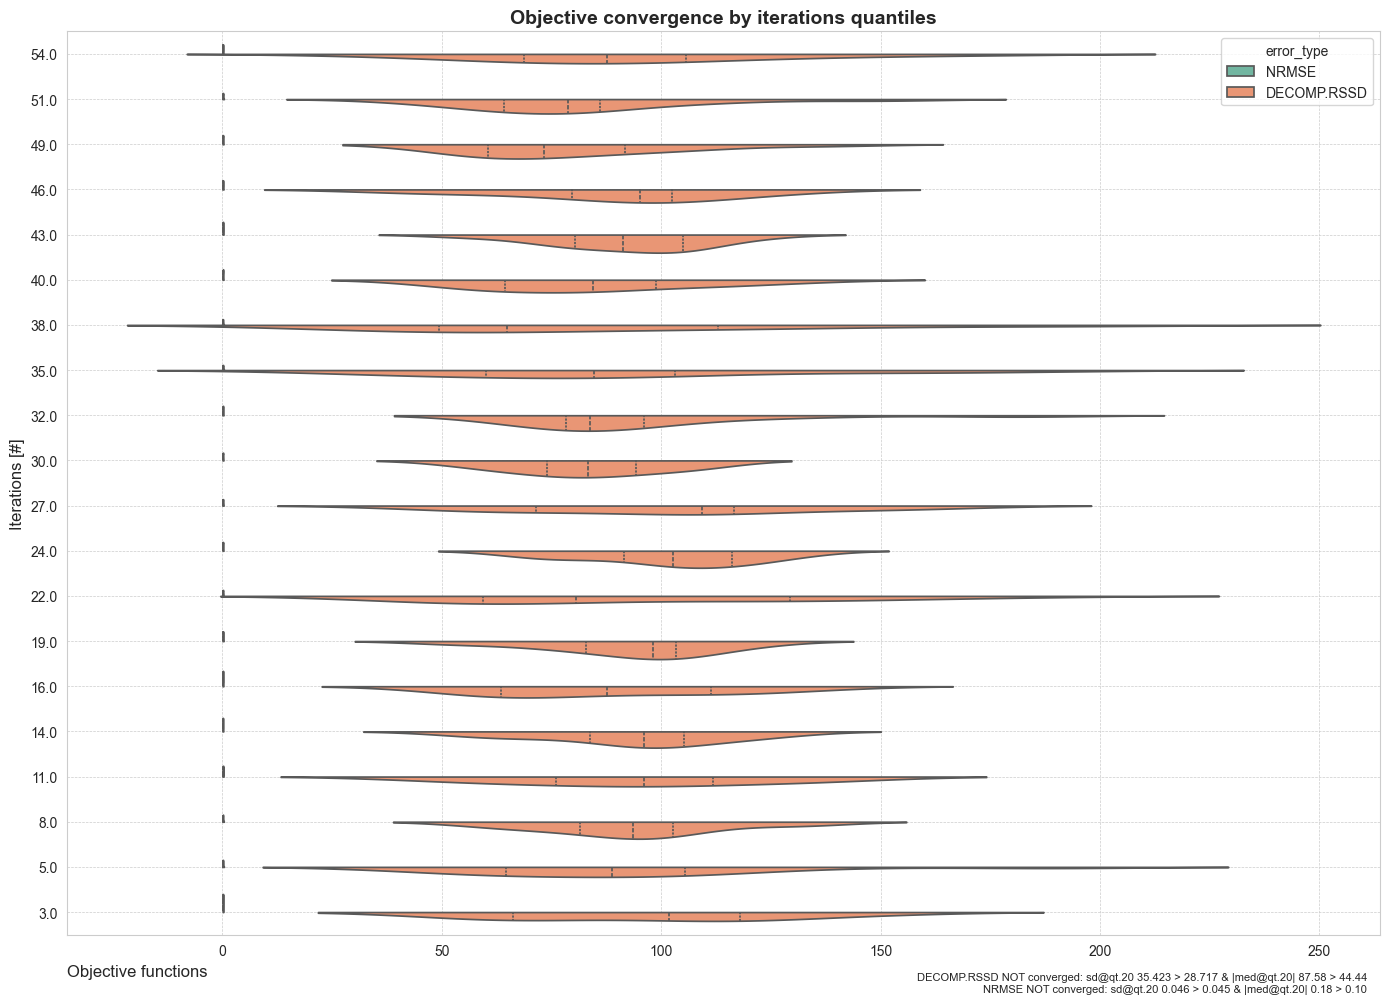

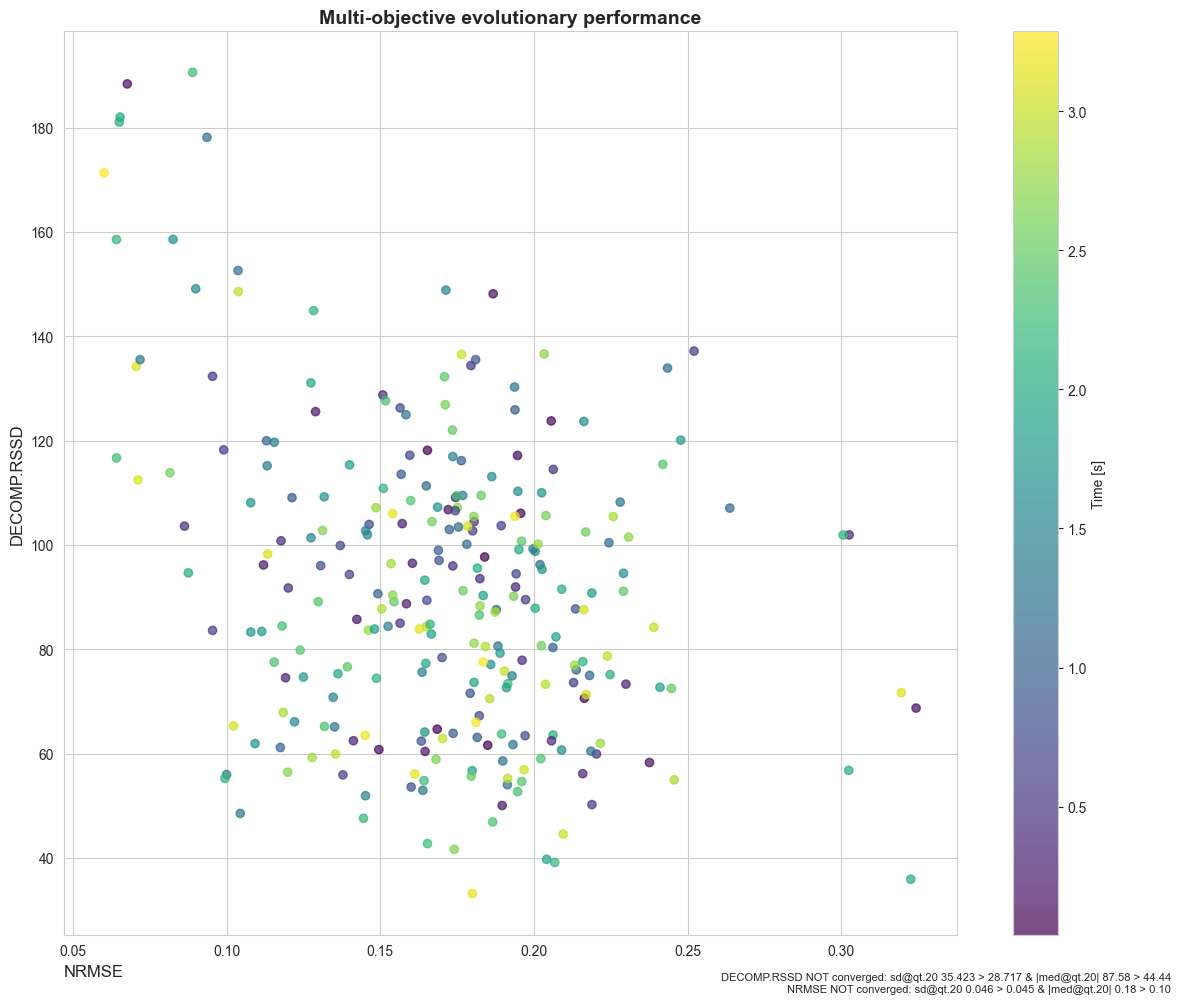

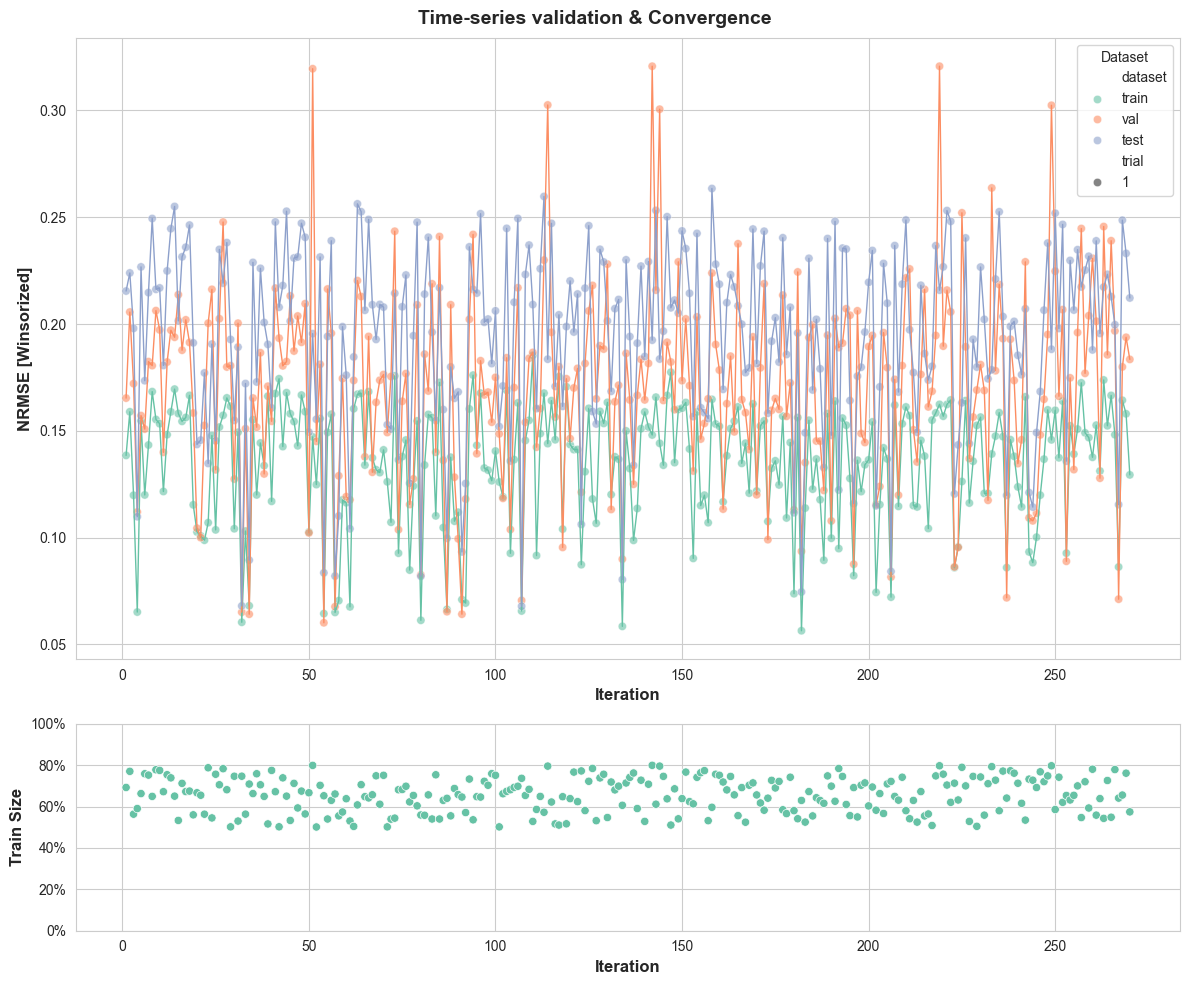

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=54, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on x cores..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

2024-11-15 04:03:57,280 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer


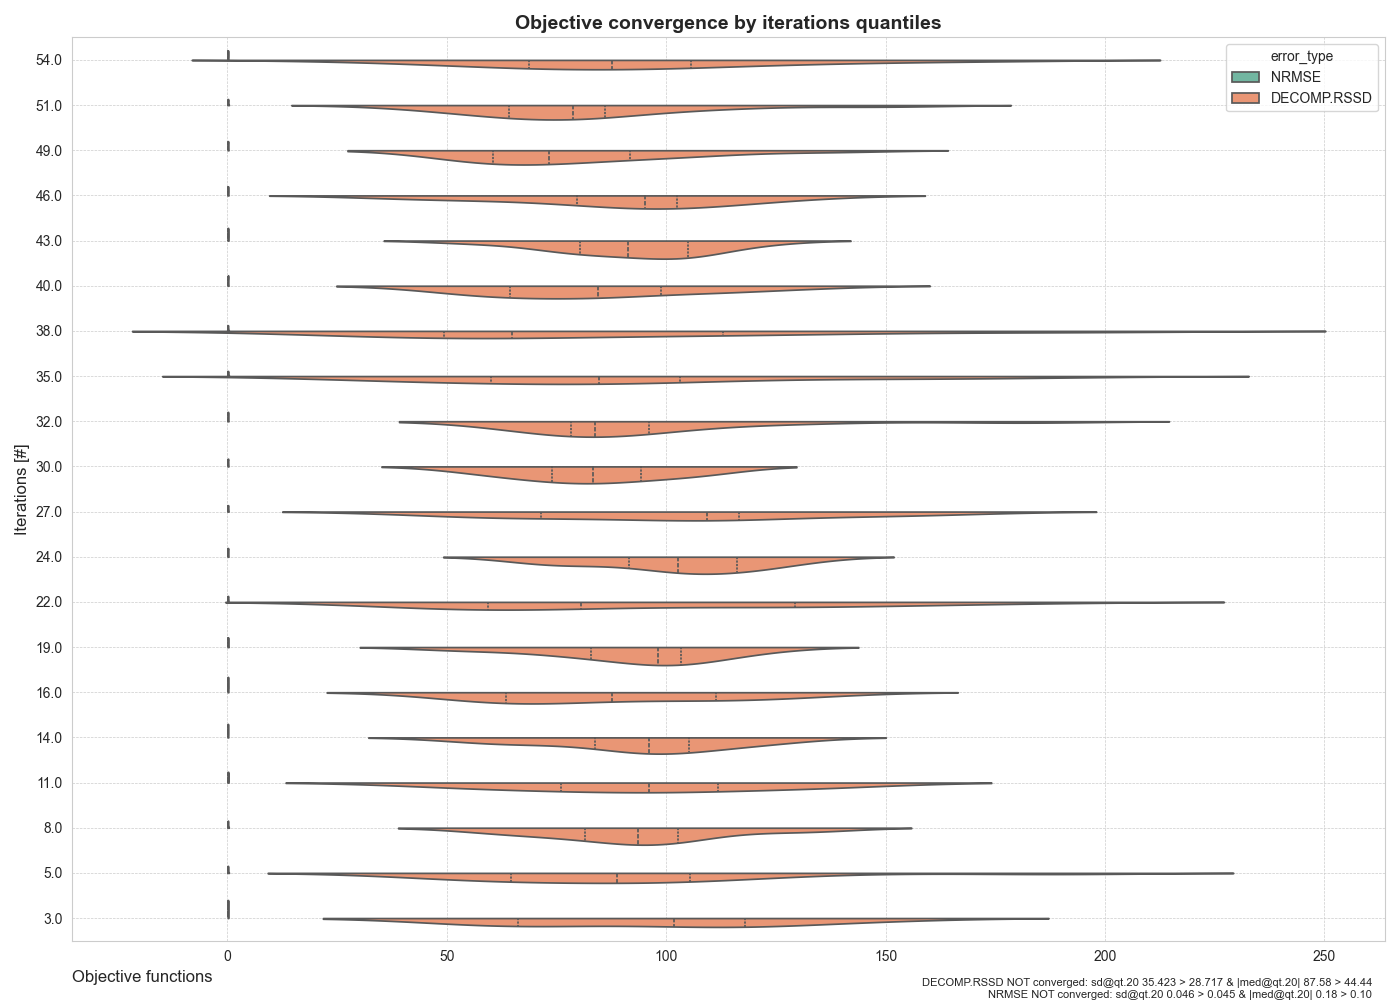

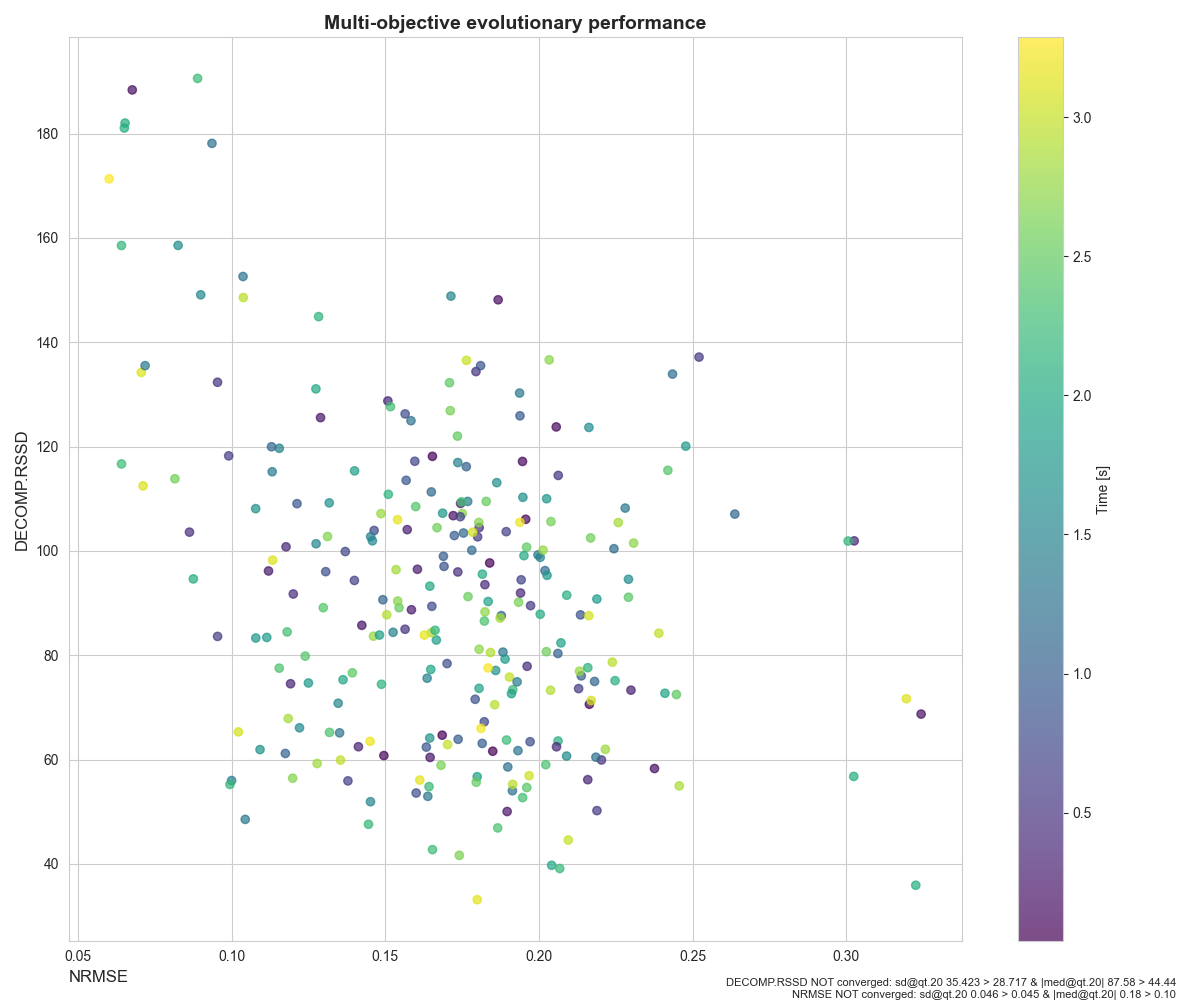

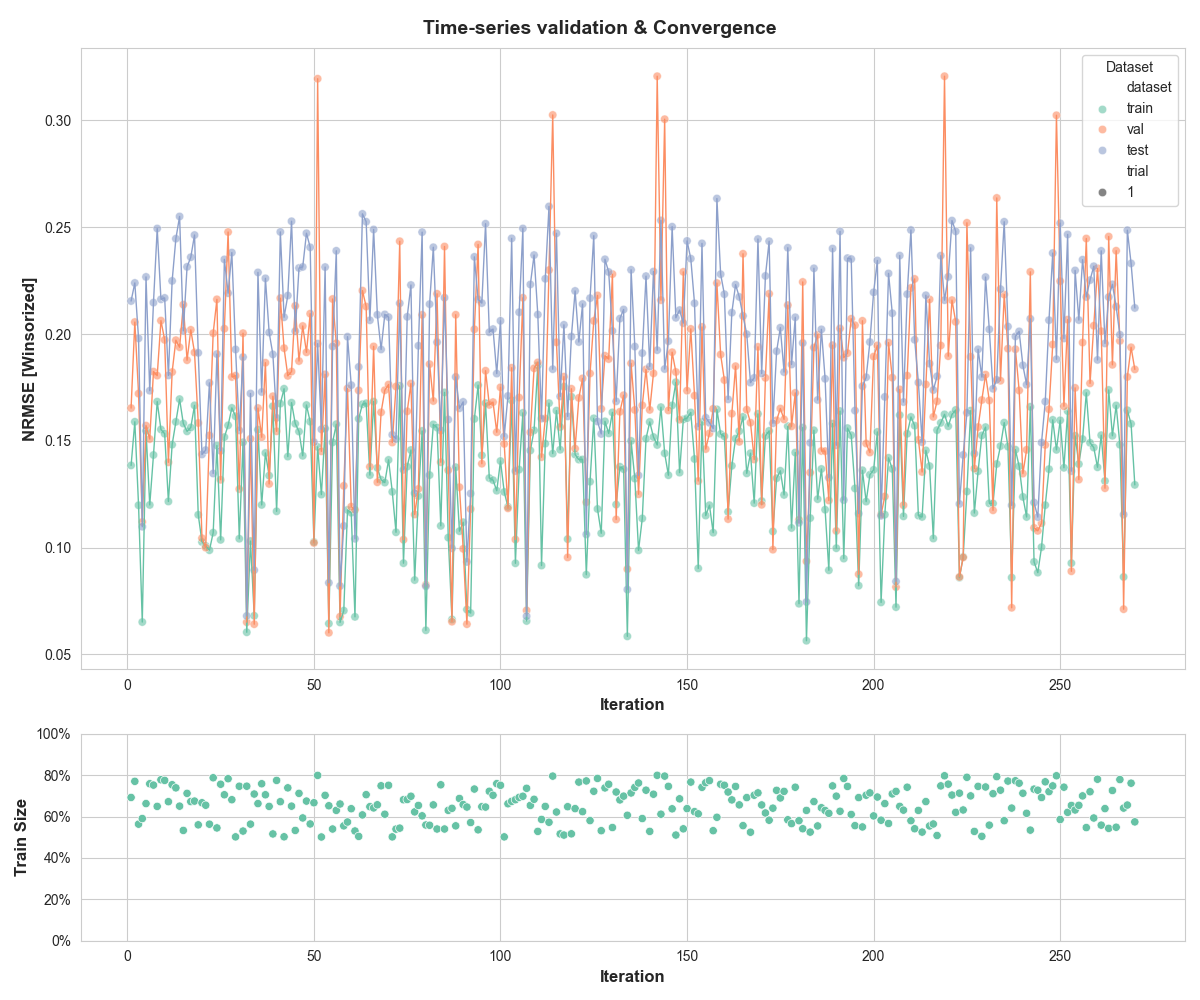

In [10]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from robyn.visualization.model_convergence_visualizer import ModelConvergenceVisualizer
%load_ext autoreload
%autoreload 2

model_visualizer = ModelConvergenceVisualizer(
    moo_distrb_plot=output_models.convergence["moo_distrb_plot"],
    ts_validation_plot=output_models.convergence["ts_validation_plot"],
    moo_cloud_plot=output_models.convergence["moo_cloud_plot"],
)

# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    model_visualizer.display_moo_distrb_plot()

# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    model_visualizer.display_moo_cloud_plot()

# 3. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    model_visualizer.display_ts_validation_plot()

In [11]:
from robyn.tutorials.utils.data_mapper import load_data_from_json, import_input_collect, import_output_models
%load_ext autoreload
%autoreload 2

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_InputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Pareto_50_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_models = import_output_models(raw_output_models)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Adjusted window_start to the closest date in the data: 2016-01-04 00:00:00
Adjusted window_end to the closest date in the data: 2018-12-31 00:00:00
Debug: R output data keys: ['trial1', 'trial2', 'trial3', 'trial4', 'trial5']
Data for trial1: Keys = ['resultCollect', 'hyperBoundNG', 'hyperBoundFixed']
Debug: resultCollect keys for trial1: ['resultHypParam', 'xDecompAgg', 'decompSpendDist', 'iter', 'elapsed.min']
Debug: Sample resultHypParam for trial1: [{'facebook_S_alphas': 1.98202923325, 'facebook_S_gammas': 0.58424338159, 'facebook_S_thetas': 0.09072730547999999, 'newsletter_alphas': 1.7514167265, 'newsletter_gammas': 0.6585122811199999, 'newsletter_thetas': 0.22826231587, 'ooh_S_alphas': 1.9350874957500002, 'ooh_S_gammas': 0.80499137605, 'ooh_S_thetas': 0.26847073588000003, 'print_S_alphas': 1.3471347205000002, 'print_S_gammas': 0.6602001640299999, 'print_S_thetas': 0.34398200833000003, 'search_

In [12]:
from anytree import Node, RenderTree
from dataclasses import is_dataclass, asdict
import pandas as pd


def build_tree(data, parent_key="", limit_trials=False, limit_repeats=False):
    """
    Recursively build a tree structure from a dictionary, list, or dataclass.

    Args:
        data: The data structure (dict, list, or dataclass) to traverse.
        parent_key: The base key path for nested keys.
        limit_trials: Whether to limit the output to the first trial.
        limit_repeats: Whether to limit the output to the first occurrence of repeated keys.

    Returns:
        A tree node representing the structure of the data.
    """
    if is_dataclass(data):
        data = asdict(data)  # Convert dataclass to dictionary

    if isinstance(data, dict):
        node = Node(f"{parent_key} (dict)")
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            child_node = build_tree(value, full_key, limit_trials, limit_repeats)
            child_node.parent = node
        return node

    elif isinstance(data, list):
        node = Node(f"{parent_key} (list, length={len(data)})")
        item_structure = None
        repeat_count = 0
        for index, item in enumerate(data):
            full_key = f"{parent_key}[{index}]"
            if limit_trials and parent_key == "trials" and index > 0:
                break

            # Serialize the structure of the item for comparison
            current_structure = (
                str({k: type(v).__name__ for k, v in item.items()}) if isinstance(item, dict) else str(type(item))
            )

            if item_structure is None:
                item_structure = current_structure
                child_node = build_tree(item, full_key, limit_trials, limit_repeats)
                child_node.parent = node
            elif current_structure == item_structure:
                repeat_count += 1
            else:
                # If the structure changes, reset the counter and process the new structure
                if repeat_count > 0:
                    summary_node = Node(f"{parent_key} (repeats for {repeat_count} times)")
                    summary_node.parent = node
                item_structure = current_structure
                repeat_count = 0
                child_node = build_tree(item, full_key, limit_trials, limit_repeats)
                child_node.parent = node

        # Add a summary node if there are repeated structures at the end
        if repeat_count > 0:
            summary_node = Node(f"{parent_key} (repeats for {repeat_count} times)")
            summary_node.parent = node

        return node

    elif isinstance(data, pd.DataFrame):
        node = Node(f"{parent_key} (DataFrame: {data.shape})")
        for column in data.columns:
            dtype = data[column].dtype
            column_node = Node(f"{parent_key}.{column} (dtype: {dtype})")
            column_node.parent = node
        return node

    else:
        dtype = type(data).__name__
        return Node(f"{parent_key} (type: {dtype})")


# Assuming featurized_mmm_data is an instance of FeaturizedMMMData
python_tree = build_tree(output_models)
r_tree = build_tree(r_output_models)

# Visualize the tree
print("Python ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")


print("-" * 100)
print("R ModelOutputs Structure:")
for pre, fill, node in RenderTree(python_tree):
    print(f"{pre}{node.name}")

Python ModelOutputs Structure:
 (dict)
├── trials (list, length=5)
│   ├── trials[0] (dict)
│   │   ├── trials[0].result_hyp_param (DataFrame: (54, 39))
│   │   │   ├── trials[0].result_hyp_param.facebook_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.facebook_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.facebook_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.print_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_alphas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.tv_S_gammas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.search_S_thetas (dtype: float64)
│   │   │   ├── trials[0].result_hyp_param.search_S_alphas (dtype: float64)
│   │   │   ├── tria

In [13]:
# from anytree import Node, RenderTree
# from anytree.exporter import DotExporter
# from dataclasses import is_dataclass, asdict
# import pandas as pd


# def build_tree(data, parent_key="", limit_trials=True):
#     """
#     Recursively build a tree structure from a dictionary, list, or dataclass.

#     Args:
#         data: The data structure (dict, list, or dataclass) to traverse.
#         parent_key: The base key path for nested keys.
#         limit_trials: Whether to limit the output to the first trial.

#     Returns:
#         A tree node representing the structure of the data.
#     """
#     if is_dataclass(data):
#         data = asdict(data)  # Convert dataclass to dictionary

#     if isinstance(data, dict):
#         node = Node(parent_key)
#         for key, value in data.items():
#             full_key = f"{parent_key}.{key}" if parent_key else key
#             child_node = build_tree(value, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, list):
#         node = Node(parent_key)
#         for index, item in enumerate(data):
#             if limit_trials and parent_key == "trials" and index > 0:
#                 break
#             full_key = f"{parent_key}[{index}]"
#             child_node = build_tree(item, full_key, limit_trials)
#             child_node.parent = node
#         return node
#     elif isinstance(data, pd.DataFrame):
#         node = Node(f"{parent_key} (DataFrame: {data.shape})")
#         for column in data.columns:
#             column_node = Node(f"{parent_key}.{column}")
#             column_node.parent = node
#         return node
#     else:
#         return Node(parent_key)


# # Assuming output_models and r_output_models are instances of ModelOutputs
# python_tree = build_tree(output_models)
# r_tree = build_tree(r_output_models)

# # Visualize the trees
# print("Python ModelOutputs Structure:")
# for pre, fill, node in RenderTree(python_tree):
#     print(f"{pre}{node.name}")

# print("\nR ModelOutputs Structure:")
# for pre, fill, node in RenderTree(r_tree):
#     print(f"{pre}{node.name}")

In [14]:
import pandas as pd
import numpy as np
from typing import Dict, Any


def compare_model_values(py_output, r_output):
    """Compare key values between Python and R model outputs"""

    print("1. Basic Model Configuration Comparison:")
    basic_attrs = [
        "train_timestamp",
        "cores",
        "iterations",
        "intercept",
        "intercept_sign",
        "nevergrad_algo",
        "ts_validation",
        "add_penalty_factor",
    ]

    # Add debug prints
    print("\nDebugging attribute types:")
    for attr in basic_attrs:
        py_val = getattr(py_output, attr, None)
        r_val = getattr(r_output, attr, None)
        print(f"{attr:20s} - Python type: {type(py_val)} | R type: {type(r_val)}")
        print(f"{attr:20s} - Python value: {py_val} | R value: {r_val}")
        print("-" * 50)

    print("\n2. Trial Results Comparison (Descriptive Statistics):")
    if py_output.trials and r_output.trials:
        metrics = [
            "nrmse",
            "decomp_rssd",
            "mape",
            "rsq_train",
            "rsq_val",
            "rsq_test",
            "lambda_",
            "lambda_hp",
            "lambda_max",
            "lambda_min_ratio",
        ]
        # Convert trial results to DataFrames
        py_trials_df = pd.DataFrame(
            [{metric: getattr(trial, metric, np.nan) for metric in metrics} for trial in py_output.trials]
        )

        # Aggregate R trial metrics
        r_trials_df = pd.DataFrame(
            [
                {metric: getattr(trial, metric, pd.Series([np.nan])).mean() for metric in metrics}
                for trial in r_output.trials
            ]
        )
        # Ensure R trial data is numeric
        r_trials_df = r_trials_df.apply(pd.to_numeric, errors="coerce")
        # Calculate descriptive statistics
        py_desc = py_trials_df.describe()
        r_desc = r_trials_df.describe()
        # Print descriptive statistics
        print("\nPython Trial Descriptive Statistics:")
        print(py_desc)
        print("\nR Trial Descriptive Statistics:")
        print(r_desc)
        # Calculate and print differences
        diff_desc = py_desc - r_desc
        print("\nDifference in Descriptive Statistics:")
        print(diff_desc)

    print("\n3. Hyperparameter Comparison:")
    if hasattr(py_output, "hyper_updated") and hasattr(r_output, "hyper_updated"):
        py_hyper = py_output.hyper_updated
        r_hyper = r_output.hyper_updated

        # Find all unique keys
        all_keys = set(py_hyper.keys()) | set(r_hyper.keys())

        print("\nHyperparameter Values:")
        print(f"{'Parameter':30s} {'Python':>15s} {'R':>15s} {'Diff':>15s}")
        print("-" * 75)

        for key in sorted(all_keys):
            py_val = py_hyper.get(key, "N/A")
            r_val = r_hyper.get(key, "N/A")

            if isinstance(py_val, (int, float)) and isinstance(r_val, (int, float)):
                diff = abs(py_val - r_val)
                print(f"{key:30s} {py_val:15.6f} {r_val:15.6f} {diff:15.6f}")
            else:
                print(f"{key:30s} {str(py_val):15s} {str(r_val):15s} {'N/A':>15s}")

    print("\n4. Data Shape Comparison:")
    data_attrs = ["all_result_hyp_param", "all_x_decomp_agg", "all_decomp_spend_dist"]

    for attr in data_attrs:
        py_shape = getattr(py_output, attr).shape if hasattr(py_output, attr) else None
        r_shape = getattr(r_output, attr).shape if hasattr(r_output, attr) else None
        print(f"{attr:20s} - Python shape: {py_shape} | R shape: {r_shape}")


# Run the comparison
print("Starting detailed value comparison...\n")
compare_model_values(output_models, r_output_models)

Starting detailed value comparison...

1. Basic Model Configuration Comparison:

Debugging attribute types:
train_timestamp      - Python type: <class 'str'> | R type: <class 'str'>
train_timestamp      - Python value: 2024-11-15 04:03:39 | R value: 2024-11-13 05:13:54
--------------------------------------------------
cores                - Python type: <class 'int'> | R type: <class 'int'>
cores                - Python value: 8 | R value: 9
--------------------------------------------------
iterations           - Python type: <class 'int'> | R type: <class 'int'>
iterations           - Python value: 54 | R value: 50
--------------------------------------------------
intercept            - Python type: <class 'bool'> | R type: <class 'bool'>
intercept            - Python value: True | R value: True
--------------------------------------------------
intercept_sign       - Python type: <class 'str'> | R type: <class 'str'>
intercept_sign       - Python value: non_negative | R value: non

In [15]:
import pandas as pd

# Set display options
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Set the display width


def get_param_dict(param):
    """Helper function to safely get parameter dictionary"""
    if hasattr(param, "__dict__"):
        return vars(param)
    elif isinstance(param, dict):
        return param
    else:
        return {}


def compare_hyperparameters(py_hyp, r_hyp):
    """Compare Hyperparameters with value previews - handles both dict and object structures"""
    print("\n=== Hyperparameters Comparison ===")
    print("\nAdstock type:")
    print(f"Python: {py_hyp.adstock}")
    print(f"R: {r_hyp.adstock}")

    # Compare hyperparameters for each channel with values
    print("\nChannel hyperparameters:")

    # Safely get channel lists
    py_channels = (
        py_hyp.hyperparameters.keys() if hasattr(py_hyp, "hyperparameters") and py_hyp.hyperparameters else []
    )
    r_channels = r_hyp.hyperparameters.keys() if hasattr(r_hyp, "hyperparameters") and r_hyp.hyperparameters else []

    # Print structure debug info
    print("\nDebug - Hyperparameters structure:")
    print(f"Python hyperparameters type: {type(py_hyp.hyperparameters)}")
    print(f"R hyperparameters type: {type(r_hyp.hyperparameters)}")

    for channel in set(py_channels) | set(r_channels):
        print(f"\nChannel: {channel}")

        # Python parameters
        if channel in py_channels:
            py_params = py_hyp.hyperparameters[channel]
            print("Python params:")
            param_dict = get_param_dict(py_params)
            for param_name, param_value in param_dict.items():
                if param_value is not None:
                    if isinstance(param_value, (list, tuple)):
                        print(f"{param_name}: {param_value[0] if param_value else None}")
                    else:
                        print(f"{param_name}: {param_value}")

        # R parameters
        if channel in r_channels:
            r_params = r_hyp.hyperparameters[channel]
            print("R params:")
            param_dict = get_param_dict(r_params)
            for param_name, param_value in param_dict.items():
                if param_value is not None:
                    if isinstance(param_value, (list, tuple)):
                        print(f"{param_name}: {param_value[0] if param_value else None}")
                    else:
                        print(f"{param_name}: {param_value}")


def describe_df_columns(df, prefix=""):
    """Helper function to describe each column in a DataFrame"""
    print(f"\n{prefix} Columns Summary:")
    for col in df.columns:
        try:
            if df[col].dtype.kind in "biufc":  # boolean, integer, unsigned integer, float, complex
                print(f"\n{col}:")
                print(df[col].describe())
        except:
            print(f"\nCould not generate statistics for {col}")


def compare_mmm_data(py_mmm_data, r_mmm_data):
    """Compare MMMData components with value previews"""
    print("\n=== MMMData Comparison ===")

    # Compare main data values
    print("\nMain data value comparison:")
    print("\nPython data summary:")
    describe_df_columns(py_mmm_data.data, "Python")
    print("\nR data summary:")
    describe_df_columns(r_mmm_data.data, "R")

    # Compare MMMDataSpec attributes
    print("\nMMMDataSpec attributes:")
    spec_attrs = [
        "all_media",
        "paid_media_spends",
        "context_vars",
        "dep_var_type",
        "rolling_window_start_which",
        "rolling_window_end_which",
        "rolling_window_length",
        "window_start",
        "window_end",
    ]

    for attr in spec_attrs:
        print(f"\n{attr}:")
        print(f"Python: {getattr(py_mmm_data.mmmdata_spec, attr)}")
        print(f"R: {getattr(r_mmm_data.mmmdata_spec, attr)}")


def compare_featurized_data(py_feat, r_feat):
    """Compare FeaturizedMMMData components with value previews"""
    print("\n=== FeaturizedMMMData Comparison ===")

    # Compare dt_mod values
    print("\ndt_mod value comparison:")
    print("\nPython dt_mod summary:")
    describe_df_columns(py_feat.dt_mod, "Python dt_mod")
    print("\nR dt_mod summary:")
    describe_df_columns(r_feat.dt_mod, "R dt_mod")

    # Compare dt_modRollWind values
    print("\ndt_modRollWind value comparison:")
    print("\nPython dt_modRollWind summary:")
    describe_df_columns(py_feat.dt_modRollWind, "Python dt_modRollWind")
    print("\nR dt_modRollWind summary:")
    describe_df_columns(r_feat.dt_modRollWind, "R dt_modRollWind")


# def compare_model_outputs(py_model, r_model):
#     """Compare ModelOutputs with value previews"""
#     print("\n=== ModelOutputs Comparison ===")

#     # Compare basic attributes
#     attrs = ["cores", "iterations", "hyper_fixed", "ts_validation"]
#     for attr in attrs:
#         if hasattr(py_model, attr) and hasattr(r_model, attr):
#             print(f"\n{attr}:")
#             print(f"Python: {getattr(py_model, attr)}")
#             print(f"R: {getattr(r_model, attr)}")

#     if py_model.trials and r_model.trials:
#         print("\n=== Last Trial Comparison ===")

#         # Compare result_hyp_param
#         print("\nResult Hyperparameter Values:")
#         if hasattr(py_model.trials[4], "result_hyp_param"):
#             print("\nPython result_hyp_param summary:")
#             describe_df_columns(py_model.trials[4].result_hyp_param, "Python")
#         if hasattr(r_model.trials[4], "result_hyp_param"):
#             print("\nR result_hyp_param summary:")
#             describe_df_columns(r_model.trials[4].result_hyp_param, "R")

#         # Compare x_decomp_agg
#         print("\nX Decomp Agg Values:")
#         if hasattr(py_model.trials[4], "x_decomp_agg"):
#             print("\nPython x_decomp_agg summary:")
#             describe_df_columns(py_model.trials[4].x_decomp_agg, "Python")
#         if hasattr(r_model.trials[4], "x_decomp_agg"):
#             print("\nR x_decomp_agg summary:")
#             describe_df_columns(r_model.trials[4].x_decomp_agg, "R")

#         # Compare decomp_spend_dist if available
#         if hasattr(py_model.trials[4], "decomp_spend_dist") and hasattr(r_model.trials[4], "decomp_spend_dist"):
#             print("\nDecomp Spend Distribution Values:")
#             print("\nPython decomp_spend_dist summary:")
#             describe_df_columns(py_model.trials[4].decomp_spend_dist, "Python")
#             print("\nR decomp_spend_dist summary:")
#             describe_df_columns(r_model.trials[4].decomp_spend_dist, "R")


def compare_model_outputs(py_model, r_model):
    """Compare ModelOutputs with value previews"""
    print("\n=== ModelOutputs Comparison ===")
    # Compare basic attributes
    attrs = ["cores", "iterations", "hyper_fixed", "ts_validation"]
    for attr in attrs:
        if hasattr(py_model, attr) and hasattr(r_model, attr):
            print(f"\n{attr}:")
            print(f"Python: {getattr(py_model, attr)}")
            print(f"R: {getattr(r_model, attr)}")
    if py_model.trials and r_model.trials:
        print("\n=== Last Trial Comparison ===")

        # Helper function to describe and stack dataframes
        def describe_and_stack(py_df, r_df, label):
            if py_df is not None and r_df is not None:
                py_desc = py_df.describe()
                r_desc = r_df.describe()
                combined = pd.concat([py_desc, r_desc], axis=1, keys=["Python", "R"])
                print(f"\n{label} summary:")
                print(combined)

        # Compare result_hyp_param
        if hasattr(py_model.trials[4], "result_hyp_param") and hasattr(r_model.trials[4], "result_hyp_param"):
            describe_and_stack(
                py_model.trials[4].result_hyp_param, r_model.trials[4].result_hyp_param, "Result Hyperparameter Values"
            )
        # Compare x_decomp_agg
        if hasattr(py_model.trials[4], "x_decomp_agg") and hasattr(r_model.trials[4], "x_decomp_agg"):
            describe_and_stack(py_model.trials[4].x_decomp_agg, r_model.trials[4].x_decomp_agg, "X Decomp Agg Values")
        # Compare decomp_spend_dist if available
        if hasattr(py_model.trials[4], "decomp_spend_dist") and hasattr(r_model.trials[4], "decomp_spend_dist"):
            describe_and_stack(
                py_model.trials[4].decomp_spend_dist,
                r_model.trials[4].decomp_spend_dist,
                "Decomp Spend Distribution Values",
            )


def run_comprehensive_comparison(py_data, r_data):
    """Run all comparisons with value previews"""
    print("Starting comprehensive data comparison...")

    # compare_mmm_data(py_data["mmm_data"], r_data["mmm_data"])
    # compare_featurized_data(py_data["featurized_mmm_data"], r_data["featurized_mmm_data"])
    # compare_hyperparameters(py_data["hyperparameters"], r_data["hyperparameters"])
    compare_model_outputs(py_data["model_outputs"], r_data["model_outputs"])


# Your existing data loading code remains the same
python_data = {
    "mmm_data": mmm_data,
    "featurized_mmm_data": featurized_mmm_data,
    "hyperparameters": hyperparameters,
    "model_outputs": output_models,
}

r_data = {
    "mmm_data": r_mmm_data,
    "featurized_mmm_data": r_featurized_mmm_data,
    "hyperparameters": r_hyperparameters,
    "model_outputs": r_output_models,
}

run_comprehensive_comparison(python_data, r_data)

Starting comprehensive data comparison...

=== ModelOutputs Comparison ===

cores:
Python: 8
R: 9

iterations:
Python: 54
R: 50

hyper_fixed:
Python: False
R: False

ts_validation:
Python: True
R: True

=== Last Trial Comparison ===

Result Hyperparameter Values summary:
                 Python                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   R                                                                                                                                                                                                                             

In [16]:
print("Python")
print(hyperparameters.hyperparameters)

print("R")
print(r_input_collect["hyperparameters"].hyperparameters)

Python
{'facebook_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'print_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'tv_S': ChannelHyperparameters(thetas=[0.3, 0.8], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'search_S': ChannelHyperparameters(thetas=[0, 0.3], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'ooh_S': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None), 'newsletter': ChannelHyperparameters(thetas=[0.1, 0.4], shapes=None, scales=None, alphas=[0.5, 3], gammas=[0.3, 1], penalty=None)}
R
{'facebook_S_alphas': [0.5, 3], 'facebook_S_gammas': [0.3, 1], 'facebook_S_thetas': [0, 0.3], 'print_S_alphas': [0.5, 3], 'print_S_gammas': [0.3, 1], 'print_S_thetas': [0.1, 0.4], 'tv_S_alphas': [0.5, 3], 'tv_S_gammas': [0.3

In [17]:
# def compare_x_decomp_agg(py_model, r_model):
#     """Compare x_decomp_agg structure and values between Python and R"""
#     print("\nComparing x_decomp_agg:")
#     print("Python columns:", py_model.all_x_decomp_agg.columns.tolist())
#     print("R columns:", r_model.all_x_decomp_agg.columns.tolist())

#     # Compare common columns statistics
#     common_cols = list(set(py_model.all_x_decomp_agg.columns) & set(r_model.all_x_decomp_agg.columns))
#     print("\nCommon columns statistics:")
#     for col in common_cols:
#         py_stats = py_model.all_x_decomp_agg[col].describe()
#         r_stats = r_model.all_x_decomp_agg[col].describe()
#         print(f"\n{col}:")
#         print("Python:", py_stats)
#         print("R:", r_stats)


# def compare_decomp_spend_dist(py_model, r_model):
#     """Compare decomp_spend_dist structure and values between Python and R"""
#     print("\nComparing decomp_spend_dist:")
#     print("Python columns:", py_model.all_decomp_spend_dist.columns.tolist())
#     print("R columns:", r_model.all_decomp_spend_dist.columns.tolist())

#     # Compare value distributions for key metrics
#     key_metrics = ["effect_share", "spend_share", "roi_total"]
#     print("\nKey metrics distributions:")
#     for metric in key_metrics:
#         if metric in py_model.all_decomp_spend_dist.columns and metric in r_model.all_decomp_spend_dist.columns:
#             print(f"\n{metric}:")
#             print("Python:", py_model.all_decomp_spend_dist[metric].describe())
#             print("R:", r_model.all_decomp_spend_dist[metric].describe())


# def compare_media_effect_calculations(py_model, r_model):
#     """Compare media effect calculations between Python and R"""
#     # Compare unique media channels
#     py_media = py_model.all_decomp_spend_dist["rn"].unique()
#     r_media = r_model.all_decomp_spend_dist["rn"].unique()

#     print("\nMedia channels comparison:")
#     print("Python channels:", sorted(py_media))
#     print("R channels:", sorted(r_media))

#     # Compare aggregated effects per channel
#     print("\nAggregated effects per channel:")
#     py_effects = py_model.all_decomp_spend_dist.groupby("rn")["xDecompAgg"].mean()
#     r_effects = r_model.all_decomp_spend_dist.groupby("rn")["xDecompAgg"].mean()

#     print("\nPython effects:")
#     print(py_effects)
#     print("\nR effects:")
#     print(r_effects)


# # Run comparisons
# print("Running detailed comparisons between Python and R outputs...")
# compare_x_decomp_agg(output_models, r_output_models)
# compare_decomp_spend_dist(output_models, r_output_models)
# compare_media_effect_calculations(output_models, r_output_models)

In [18]:
def print_data_structure(data):
    print("Columns:", data.columns.tolist())
    print("\nFirst row:", data.iloc[0].to_dict())
    print("\nShape:", data.shape)


# Assuming you want to print the structure for the first trial
first_trial_r = r_output_models.trials[0].decomp_spend_dist
first_trial_python = output_models.trials[0].decomp_spend_dist

print("R exported data structure:")
print_data_structure(first_trial_r)

# With Python calculated data
print("\nPython calculated data structure:")
print_data_structure(first_trial_python)

R exported data structure:
Columns: ['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0', 'xDecompMeanNon0Perc', 'xDecompAggRF', 'xDecompPercRF', 'xDecompMeanNon0RF', 'xDecompMeanNon0PercRF', 'pos', 'mean_spend', 'total_spend', 'spend_share', 'spend_share_refresh', 'effect_share', 'effect_share_refresh', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse_train', 'nrmse_val', 'nrmse_test', 'nrmse', 'decomp.rssd', 'mape', 'lambda', 'lambda_hp', 'lambda_max', 'lambda_min_ratio', 'sol_id', 'trial', 'iterNG', 'iterPar']

First row: {'rn': 'tv_S', 'coef': 85541.42082097995, 'xDecompAgg': 2170906.4549621465, 'xDecompPerc': 0.007778859372366383, 'xDecompMeanNon0': 13827.429649440432, 'xDecompMeanNon0Perc': 0.00775628544138919, 'xDecompAggRF': 2170906.4549621465, 'xDecompPercRF': 0.007778859372366383, 'xDecompMeanNon0RF': 13827.429649440432, 'xDecompMeanNon0PercRF': 0.00775628544138919, 'pos': True, 'mean_spend': 16505.80985031847, 'total_spend': 2591412.1465000007, 'spend_share': 0.2060473626